In [1]:
%%bash

# Keep only most recent CSV files for each model pattern

cd output/csv 2>/dev/null || { echo "output/csv directory not found, skipping cleanup"; exit 0; }

for pattern in "llama_batch_results_*.csv" "internvl3_batch_results_*.csv" "internvl3_non_quantized_batch_results_*.csv"; do
    files=($(ls -t $pattern 2>/dev/null))
    
    if [ ${#files[@]} -gt 1 ]; then
        echo "Pattern: $pattern"
        echo "  Keeping: ${files[0]}"
        echo "  Deleting $((${#files[@]}-1)) older files..."
        
        for ((i=1; i<${#files[@]}; i++)); do
            rm "${files[$i]}"
            echo "    ✗ Deleted: ${files[$i]}"
        done
    elif [ ${#files[@]} -eq 1 ]; then
        echo "Pattern: $pattern - 1 file (kept)"
    else
        echo "Pattern: $pattern - no files found"
    fi
done

cd ../..
echo "✅ Cleanup complete"


Pattern: llama_batch_results_*.csv - 1 file (kept)
Pattern: internvl3_batch_results_*.csv - 1 file (kept)
Pattern: internvl3_non_quantized_batch_results_*.csv - 1 file (kept)
✅ Cleanup complete


# Model Comparison: Llama vs InternVL3

**Business Document Processing Performance Analysis**

---

This notebook provides a comprehensive side-by-side comparison of Llama-3.2-Vision-11B and InternVL3-8B models for business document information extraction.

## Key Business Questions Addressed:
1. **Accuracy**: Which model extracts information more reliably?
2. **Speed**: Which model processes documents faster?
3. **Document Type Performance**: How do models perform on invoices, receipts, and bank statements?
4. **Resource Efficiency**: Which model provides better ROI?
5. **Production Readiness**: Which model is recommended for deployment?

## 1. Setup and Configuration

In [2]:
# Cell 2

import warnings
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from rich import print as rprint
from rich.console import Console

warnings.filterwarnings('ignore')
console = Console()

# Set professional styling for executive presentation
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Configuration with flexible path handling - consistent with batch notebooks
# Define base path for flexible deployment

base_data_path = '/home/jovyan/nfs_share/tod/LMM_POC'
# base_data_path = '/home/jovyan/LMM_POC-oct6'
# base_data_path = '/home/jovyan/_LMM_POC'

CONFIG = {
    # Path settings - Now supports both absolute and relative paths
    'output_dir': f'{base_data_path}/output/csv',  # Can be relative or absolute path
    'ground_truth_path': f'{base_data_path}/evaluation_data/ground_truth.csv',  # Ground truth for field accuracy

    # 'ground_truth_path': f'{base_data_path}/evaluation_data/lmm_poc_gt_20251111.csv',  # Ground truth for field accuracy
    
    # UPDATED: File patterns matching new notebook naming conventions
    # Current naming: llama_batch_results_*.csv, internvl3_batch_results_*.csv, etc.
    'llama_pattern': 'llama_batch_results_*.csv',
    'internvl3_quantized_pattern': 'internvl3_batch_results_*.csv',  # Matches quantized InternVL3 (2B or 8B)
    'internvl3_non_quantized_pattern': 'internvl3_non_quantized_batch_results_*.csv',  # Matches non-quantized
    
    # Visualization settings
    'figure_size': (16, 10),
    'dpi': 300,
    'save_format': 'png'
}

# Examples of flexible path configuration:
# Relative paths (relative to current working directory):
#   'output_dir': 'output/csv'
#
# Absolute paths (can be anywhere on the system):
#   'output_dir': '/home/user/results/vision_model_outputs/csv'
#
# Environment variable based paths:
#   'output_dir': os.path.join(os.getenv('OUTPUT_DIR', 'output'), 'csv')
#
# Dynamic paths based on other locations:
#   base_results_path = '/mnt/shared_data/vision_results'
#   'output_dir': f'{base_results_path}/csv'

print("✅ Model comparison configuration loaded")
print(f"📁 Output directory: {CONFIG['output_dir']}")
print(f"🔍 Looking for CSV files in: {Path(CONFIG['output_dir']).absolute()}")

✅ Model comparison configuration loaded
📁 Output directory: /home/jovyan/nfs_share/tod/LMM_POC/output/csv
🔍 Looking for CSV files in: /home/jovyan/nfs_share/tod/LMM_POC/output/csv


## 2. Data Loading and Preparation

In [3]:
# Cell 4

def load_latest_results(output_dir: str, pattern: str, model_name: str) -> pd.DataFrame:
    """
    Load the most recent CSV results file matching the given pattern.
    
    Args:
        output_dir: Directory to search for files (supports absolute and relative paths)
        pattern: Glob pattern to match files
        model_name: Name of the model for the 'model' column
        
    Returns:
        DataFrame with results, or empty DataFrame if no files found
    """
    import glob
    from pathlib import Path
    
    # Handle both absolute and relative paths
    output_path = Path(output_dir)
    if not output_path.is_absolute():
        # If relative, make it relative to current working directory
        output_path = Path.cwd() / output_path
    
    search_path = output_path / pattern
    files = glob.glob(str(search_path))
    
    if not files:
        rprint(f"[yellow]⚠️ No files found matching pattern: {pattern}[/yellow]")
        rprint(f"[dim]   Searched in: {output_path}[/dim]")
        return pd.DataFrame()
    
    # Get the most recent file
    latest_file = max(files, key=lambda x: Path(x).stat().st_mtime)
    rprint(f"[green]✅ Loading {model_name} data from: {Path(latest_file).name}[/green]")
    
    try:
        df = pd.read_csv(latest_file)
        
        # Add model column if it doesn't exist
        if 'model' not in df.columns:
            df['model'] = model_name
        
        # Ensure required columns exist
        required_cols = ['overall_accuracy', 'processing_time', 'document_type']
        missing_cols = [col for col in required_cols if col not in df.columns]
        
        if missing_cols:
            rprint(f"[yellow]⚠️ Missing columns in {model_name} data: {missing_cols}[/yellow]")
            # Create dummy columns with default values
            for col in missing_cols:
                if col == 'overall_accuracy':
                    df[col] = 0.0
                elif col == 'processing_time':
                    df[col] = 1.0
                elif col == 'document_type':
                    df[col] = 'unknown'
        
        return df
        
    except Exception as e:
        rprint(f"[red]❌ Error loading {model_name} data from {latest_file}: {e}[/red]")
        return pd.DataFrame()

In [4]:
# Cell 5

# Load data for all available models
rprint("[bold blue]📊 Loading Model Performance Data[/bold blue]")

llama_df = load_latest_results(CONFIG['output_dir'], CONFIG['llama_pattern'], 'Llama-3.2-Vision')
internvl3_quantized_df = load_latest_results(CONFIG['output_dir'], CONFIG['internvl3_quantized_pattern'], 'InternVL3-Quantized-8B')
internvl3_non_quantized_df = load_latest_results(CONFIG['output_dir'], CONFIG['internvl3_non_quantized_pattern'], 'InternVL3-NonQuantized-2B')

# Combine all available dataframes
dfs_to_concat = []
if not llama_df.empty:
    dfs_to_concat.append(llama_df)
if not internvl3_quantized_df.empty:
    dfs_to_concat.append(internvl3_quantized_df)
if not internvl3_non_quantized_df.empty:
    dfs_to_concat.append(internvl3_non_quantized_df)

if dfs_to_concat:
    combined_df = pd.concat(dfs_to_concat, ignore_index=True)
    rprint(f"[green]✅ Combined dataset: {len(combined_df)} records from {len(dfs_to_concat)} models[/green]")
    
    # Show what models were loaded
    loaded_models = combined_df['model'].unique()
    rprint(f"[cyan]📋 Models loaded: {', '.join(loaded_models)}[/cyan]")
else:
    rprint("[red]❌ No data loaded for any model[/red]")
    rprint("\n[yellow]💡 To use this notebook:[/yellow]")
    rprint("  1. Run llama_batch.ipynb to generate Llama results")
    rprint("  2. Run ivl3_batch.ipynb to generate InternVL3 quantized results")
    rprint("  3. Run ivl3_8b_batch_non_quantized.ipynb for non-quantized results")
    rprint("  4. Re-run this notebook to generate the comparison")
    combined_df = pd.DataFrame()

📊 Loading Model Performance Data

✅ Loading Llama-3.2-Vision data from: llama_batch_results_20251113_215113.csv

✅ Loading InternVL3-Quantized-8B data from: internvl3_batch_results_20251113_215741.csv

✅ Loading InternVL3-NonQuantized-2B data from: internvl3_non_quantized_batch_results_20251113_220555.csv

✅ Combined dataset: 27 records from 3 models

📋 Models loaded: Llama-3.2-Vision, InternVL3-Quantized-8B, InternVL3-NonQuantized-2B

In [5]:
# Cell 6

def generate_executive_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate executive summary statistics from combined model data.
    
    Args:
        df: Combined DataFrame with all model results
        
    Returns:
        DataFrame with summary statistics per model
    """
    if df.empty:
        return pd.DataFrame()
    
    summary_stats = df.groupby('model').agg({
        'overall_accuracy': ['mean', 'std', 'min', 'max'],
        'processing_time': ['mean', 'std', 'min', 'max'],
        'fields_extracted': 'mean',
        'fields_matched': 'mean'
    }).round(2)
    
    # Flatten column names
    summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
    
    # Calculate throughput (documents per minute)
    summary_stats['throughput_docs_per_min'] = (60 / summary_stats['processing_time_mean']).round(2)
    
    # Calculate efficiency score (accuracy × throughput)
    summary_stats['efficiency_score'] = (summary_stats['overall_accuracy_mean'] * summary_stats['throughput_docs_per_min']).round(2)
    
    return summary_stats.reset_index()

📊 Creating Executive Dashboard

✅ Executive dashboard saved to: output/visualizations/executive_comparison_20251114_003531.png

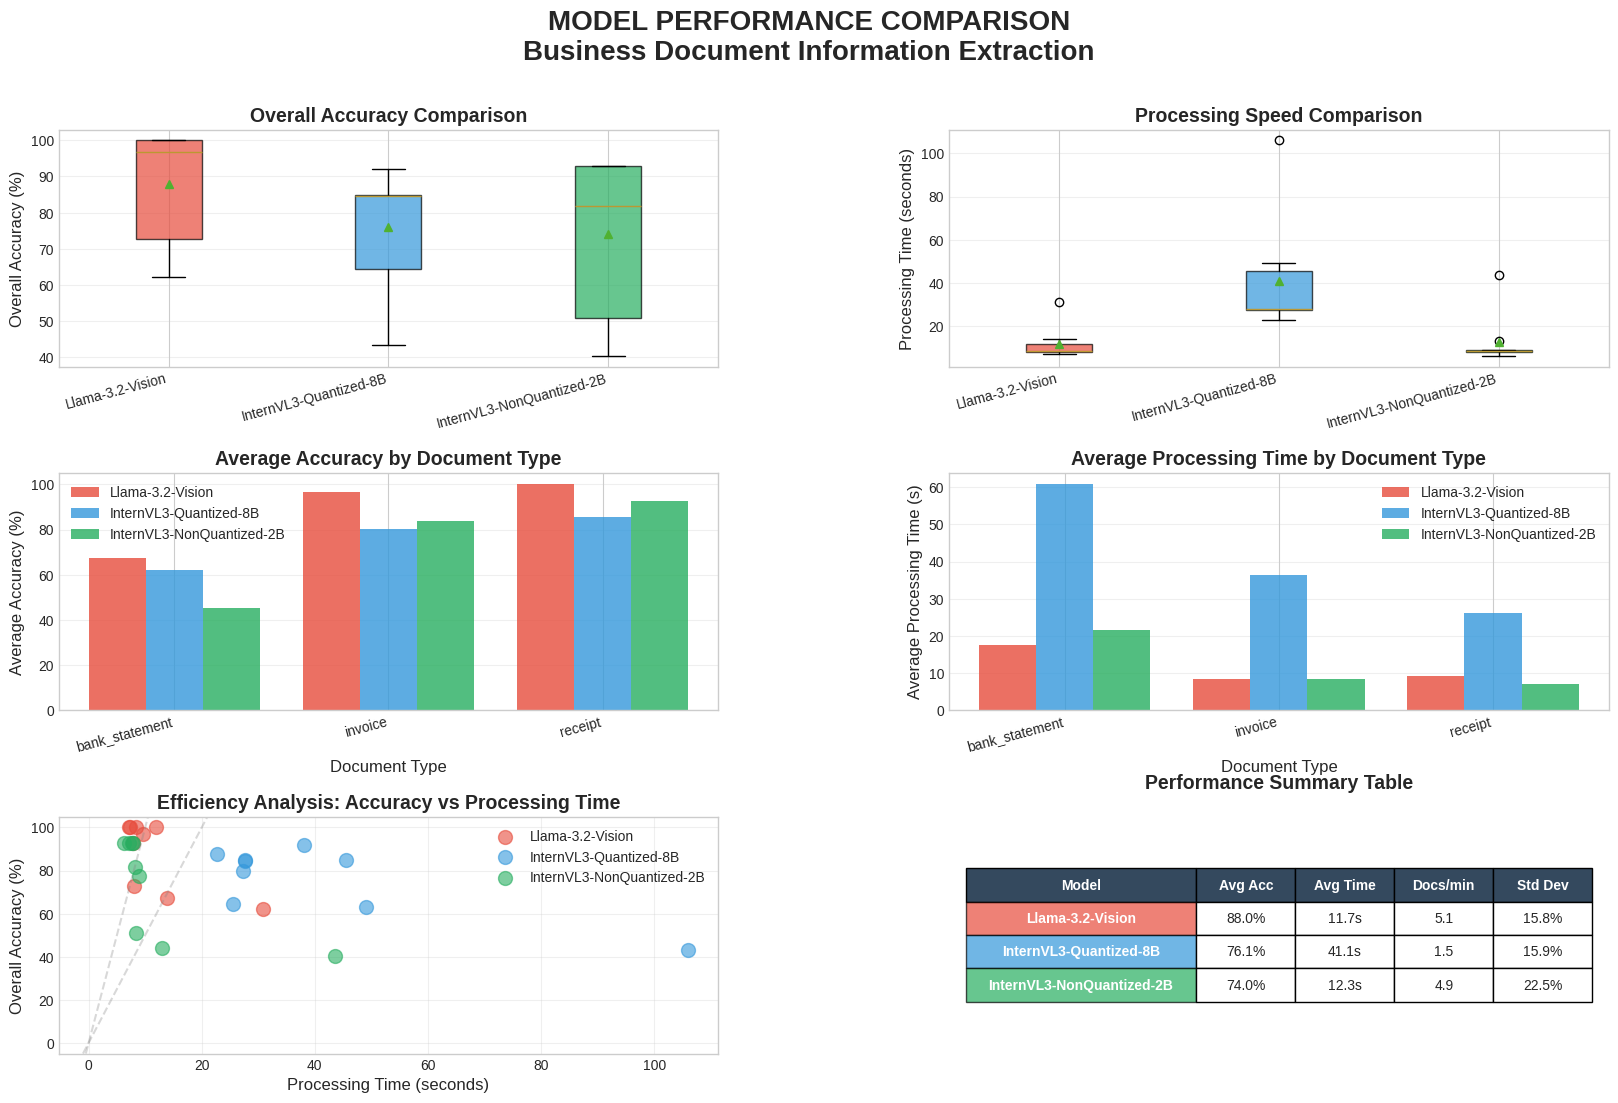

✅ Executive dashboard created successfully

In [6]:
# Cell 7

def create_executive_dashboard(df: pd.DataFrame, save_path: str = None):
    """
    Create comprehensive 6-panel executive dashboard comparing model performance.
    
    Args:
        df: Combined DataFrame with results from all models
        save_path: Optional path to save the visualization
    """
    if df.empty:
        rprint("[red]❌ Cannot create dashboard - no data available[/red]")
        return
    
    # Define model order and colors for consistency
    model_order = ['Llama-3.2-Vision', 'InternVL3-Quantized-8B', 'InternVL3-NonQuantized-2B']
    fixed_colors = {
        'Llama-3.2-Vision': '#E74C3C',
        'InternVL3-Quantized-8B': '#3498DB', 
        'InternVL3-NonQuantized-2B': '#27AE60'
    }
    
    # Filter to only available models and maintain order
    available_models = df['model'].unique()
    models = [model for model in model_order if model in available_models]
    model_colors = [fixed_colors[model] for model in models if model in fixed_colors]
    
    # Create figure with 6 subplots
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], hspace=0.45, wspace=0.35)
    
    # 1. Overall Accuracy Comparison (Box Plot)
    ax1 = fig.add_subplot(gs[0, 0])
    df_plot = df[df['model'].isin(models)]
    
    box_parts = ax1.boxplot(
        [df_plot[df_plot['model'] == model]['overall_accuracy'].values for model in models],
        labels=models,
        patch_artist=True,
        showmeans=True
    )
    
    for patch, color in zip(box_parts['boxes'], model_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_ylabel('Overall Accuracy (%)', fontsize=12)
    ax1.set_title('Overall Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_xticklabels(models, rotation=15, ha='right')
    
    # 2. Processing Speed Comparison (Box Plot)
    ax2 = fig.add_subplot(gs[0, 1])
    
    box_parts = ax2.boxplot(
        [df_plot[df_plot['model'] == model]['processing_time'].values for model in models],
        labels=models,
        patch_artist=True,
        showmeans=True
    )
    
    for patch, color in zip(box_parts['boxes'], model_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2.set_ylabel('Processing Time (seconds)', fontsize=12)
    ax2.set_title('Processing Speed Comparison', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_xticklabels(models, rotation=15, ha='right')
    
    # 3. Average Accuracy by Document Type (Grouped Bar Chart)
    ax3 = fig.add_subplot(gs[1, 0])
    
    doc_accuracy = df_plot.groupby(['document_type', 'model'])['overall_accuracy'].mean().unstack()
    doc_accuracy = doc_accuracy[models]  # Ensure correct order
    
    x = np.arange(len(doc_accuracy.index))
    width = 0.8 / len(models)
    
    for idx, model in enumerate(models):
        offset = (idx - len(models)/2 + 0.5) * width
        ax3.bar(x + offset, doc_accuracy[model], width, 
               label=model, color=fixed_colors[model], alpha=0.8)
    
    ax3.set_ylabel('Average Accuracy (%)', fontsize=12)
    ax3.set_xlabel('Document Type', fontsize=12)
    ax3.set_title('Average Accuracy by Document Type', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(doc_accuracy.index, rotation=15, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Average Processing Time by Document Type (Grouped Bar Chart)
    ax4 = fig.add_subplot(gs[1, 1])
    
    doc_time = df_plot.groupby(['document_type', 'model'])['processing_time'].mean().unstack()
    doc_time = doc_time[models]  # Ensure correct order
    
    for idx, model in enumerate(models):
        offset = (idx - len(models)/2 + 0.5) * width
        ax4.bar(x + offset, doc_time[model], width,
               label=model, color=fixed_colors[model], alpha=0.8)
    
    ax4.set_ylabel('Average Processing Time (s)', fontsize=12)
    ax4.set_xlabel('Document Type', fontsize=12)
    ax4.set_title('Average Processing Time by Document Type', fontsize=14, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(doc_time.index, rotation=15, ha='right')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. Efficiency Analysis: Accuracy vs Processing Time (Scatter Plot)
    ax5 = fig.add_subplot(gs[2, 0])
    
    for model in models:
        model_data = df_plot[df_plot['model'] == model]
        ax5.scatter(model_data['processing_time'], model_data['overall_accuracy'],
                   label=model, color=fixed_colors[model], alpha=0.6, s=100)
    
    ax5.set_xlabel('Processing Time (seconds)', fontsize=12)
    ax5.set_ylabel('Overall Accuracy (%)', fontsize=12)
    ax5.set_title('Efficiency Analysis: Accuracy vs Processing Time', fontsize=14, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Add diagonal efficiency lines
    ax5.axline((0, 0), slope=10, color='gray', linestyle='--', alpha=0.3, label='10% per second')
    ax5.axline((0, 0), slope=5, color='gray', linestyle='--', alpha=0.3, label='5% per second')
    
    # 6. Performance Summary Table
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.axis('off')
    
    # Generate summary statistics
    summary_data = []
    for model in models:
        model_data = df_plot[df_plot['model'] == model]
        summary_data.append([
            model,
            f"{model_data['overall_accuracy'].mean():.1f}%",
            f"{model_data['processing_time'].mean():.1f}s",
            f"{(60 / model_data['processing_time'].mean()):.1f}",
            f"{model_data['overall_accuracy'].std():.1f}%"
        ])
    
    table = ax6.table(cellText=summary_data,
                     colLabels=['Model', 'Avg Acc', 'Avg Time', 'Docs/min', 'Std Dev'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.35, 0.15, 0.15, 0.15, 0.15])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Color header row
    for i in range(5):
        table[(0, i)].set_facecolor('#34495E')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color data rows with model colors
    for i, model in enumerate(models):
        if model in fixed_colors:
            table[(i+1, 0)].set_facecolor(fixed_colors[model])
            table[(i+1, 0)].set_text_props(color='white', weight='bold')
            table[(i+1, 0)].set_alpha(0.7)
    
    ax6.set_title('Performance Summary Table', fontsize=14, fontweight='bold', pad=20)
    
    # Overall title
    fig.suptitle('MODEL PERFORMANCE COMPARISON\nBusiness Document Information Extraction',
                fontsize=20, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    
    # Save the visualization
    if save_path:
        plt.savefig(save_path, dpi=CONFIG['dpi'], bbox_inches='tight')
        rprint(f"[green]✅ Executive dashboard saved to: {save_path}[/green]")
    
    plt.show()

# Create the executive dashboard
dashboard_timestamp = None
if not combined_df.empty:
    rprint("\n[bold blue]📊 Creating Executive Dashboard[/bold blue]")
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = Path(f"output/visualizations/executive_comparison_{timestamp}.png")
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    create_executive_dashboard(combined_df, str(output_path))
    dashboard_timestamp = timestamp
    
    rprint(f"[green]✅ Executive dashboard created successfully[/green]")
else:
    rprint("[red]❌ Cannot create executive dashboard - no data available[/red]")

In [7]:
# Cell 8

def extract_field_level_accuracy_from_csv(output_dir: str, pattern: str, model_name: str, ground_truth_path: str) -> pd.DataFrame:
    """
    Extract field-level accuracy by comparing CSV batch results against ground truth.
    
    This function:
    1. Loads batch results CSV (which has extracted field values)
    2. Loads ground truth CSV
    3. Compares field-by-field using the SAME evaluation logic as llama_batch.ipynb
    4. Returns per-field accuracy WITHOUT re-running document-type filtering
    
    Args:
        output_dir: Directory containing batch results CSV files
        pattern: Glob pattern to match files  
        model_name: Name of the model
        ground_truth_path: Path to ground truth CSV
        
    Returns:
        DataFrame with columns: model, field_name, accuracy, correct_count, total_count
    """
    import glob
    from pathlib import Path
    import sys
    sys.path.insert(0, str(Path.cwd()))
    
    from common.evaluation_metrics import load_ground_truth, calculate_field_accuracy
    
    output_path = Path(output_dir)
    if not output_path.is_absolute():
        output_path = Path.cwd() / output_path
    
    search_path = output_path / pattern  
    files = glob.glob(str(search_path))
    
    if not files:
        rprint(f"[yellow]⚠️ No batch results found: {pattern}[/yellow]")
        rprint(f"[dim]   Searched in: {output_path}[/dim]")
        return pd.DataFrame()
    
    # Get the most recent file
    latest_file = max(files, key=lambda x: Path(x).stat().st_mtime)
    rprint(f"[cyan]📄 Evaluating {model_name} from: {Path(latest_file).name}[/cyan]")
    
    try:
        # Load batch results CSV
        batch_df = pd.read_csv(latest_file)
        total_images = len(batch_df)
        rprint(f"[dim]  DEBUG: Loaded {total_images} rows from batch CSV[/dim]")
        
        # Load ground truth
        gt_path = Path(ground_truth_path)
        if not gt_path.exists():
            rprint(f"[red]  ❌ Ground truth not found: {ground_truth_path}[/red]")
            return pd.DataFrame()
            
        ground_truth_map = load_ground_truth(str(gt_path), show_sample=False, verbose=False)
        rprint(f"[dim]  DEBUG: Ground truth has {len(ground_truth_map)} entries[/dim]")
        
        # Determine which column to use for matching
        # Ground truth uses image_file, batch CSV has both image_file and image_name
        image_col = 'image_file' if 'image_file' in batch_df.columns else 'image_name'
        
        # DEBUG: Show sample image names
        if len(batch_df) > 0:
            sample_batch_names = batch_df[image_col].head(3).tolist()
            rprint(f"[dim]  DEBUG: Sample batch image names (from {image_col}): {sample_batch_names}[/dim]")
        
        if len(ground_truth_map) > 0:
            sample_gt_names = list(ground_truth_map.keys())[:3]
            rprint(f"[dim]  DEBUG: Sample ground truth names: {sample_gt_names}[/dim]")

        # FIX: Normalize image names by stripping extensions for matching
        # Batch CSV has extensions (.jpeg, .png), ground truth does not
        batch_df['image_stem'] = batch_df[image_col].apply(lambda x: Path(x).stem)

        # Create ground truth mapping with stems as keys
        ground_truth_by_stem = {}
        for gt_name, gt_data in ground_truth_map.items():
            stem = Path(str(gt_name)).stem  # Strip extension if present
            ground_truth_by_stem[stem] = gt_data

        rprint(f"[dim]  DEBUG: Created stem-based mapping for {len(ground_truth_by_stem)} ground truth entries[/dim]")


        
        # FILTER: Only evaluate images that have ground truth
        # FIX: Match using image_file column (consistent with ground truth)
        batch_df_filtered = batch_df[batch_df['image_stem'].isin(ground_truth_by_stem.keys())]
        filtered_count = len(batch_df_filtered)
        skipped_count = total_images - filtered_count
        
        rprint(f"[dim]  DEBUG: Filtered to {filtered_count} matching images (skipped {skipped_count})[/dim]")
        
        if filtered_count == 0:
            rprint(f"[red]  ❌ No images in batch match ground truth entries[/red]")
            return pd.DataFrame()
        
        rprint(f"[cyan]  📊 Evaluating {filtered_count}/{total_images} images with ground truth[/cyan]")
        
        # Track field accuracies - accumulate across all images
        field_accuracies = {}
        
        # Get all possible field columns (exclude metadata columns)
        metadata_cols = {'image_file', 'image_name', 'document_type', 'processing_time', 
                         'field_count', 'found_fields', 'field_coverage', 'prompt_used', 
                         'timestamp', 'overall_accuracy', 'fields_extracted', 'fields_matched', 
                         'total_fields', 'inference_only', 'model', 'image_stem'}
        
        field_columns = [col for col in batch_df_filtered.columns if col not in metadata_cols]
        
        rprint(f"[dim]  DEBUG: Found {len(field_columns)} field columns to evaluate[/dim]")
        
        # Evaluate each image
        for _, row in batch_df_filtered.iterrows():
            image_identifier = row[image_col]
            
            # Get ground truth for this image (use image_identifier as key)
            # Get ground truth using stem (without extension)
            image_stem = Path(str(image_identifier)).stem
            gt_data = ground_truth_by_stem.get(image_stem)
            if not gt_data:
                continue
            
            # Compare each field
            for field_name in field_columns:
                extracted_value = row.get(field_name, 'NOT_FOUND')
                ground_truth_value = gt_data.get(field_name, 'NOT_FOUND')
                
                # Skip if both are NOT_FOUND (field not applicable)
                if str(extracted_value).upper() == 'NOT_FOUND' and str(ground_truth_value).upper() == 'NOT_FOUND':
                    continue
                
                # Calculate accuracy score using the same logic as batch notebooks
                accuracy_score = calculate_field_accuracy(
                    extracted_value, ground_truth_value, field_name, debug=False
                )
                
                # Initialize field tracking if needed
                if field_name not in field_accuracies:
                    field_accuracies[field_name] = {'correct': 0.0, 'total': 0}
                
                field_accuracies[field_name]['total'] += 1
                field_accuracies[field_name]['correct'] += accuracy_score
        
        rprint(f"[dim]  DEBUG: Computed accuracies for {len(field_accuracies)} fields[/dim]")
        
        if not field_accuracies:
            rprint(f"[yellow]  ⚠️ No field accuracies computed[/yellow]")
            return pd.DataFrame()
        
        # Convert to DataFrame
        field_data = []
        for field_name, data in field_accuracies.items():
            accuracy = data['correct'] / data['total'] if data['total'] > 0 else 0.0
            field_data.append({
                'model': model_name,
                'field_name': field_name,
                'accuracy': accuracy,
                'correct_count': data['correct'],
                'total_count': data['total']
            })
        
        # Calculate average accuracy
        avg_accuracy = sum(d['accuracy'] for d in field_data) / len(field_data) if field_data else 0.0
        
        rprint(f"[green]  ✅ Computed accuracy for {len(field_data)} fields (avg: {avg_accuracy:.1%})[/green]")
        return pd.DataFrame(field_data)
        
    except Exception as e:
        rprint(f"[red]❌ Error evaluating {model_name}: {e}[/red]")
        import traceback
        rprint(f"[dim]{traceback.format_exc()}[/dim]")
        return pd.DataFrame()

# Load field-level accuracy data from CSV files (NOT re-running evaluation)
rprint("\n[bold blue]📊 Computing Field-Level Accuracy (from CSV + Ground Truth)[/bold blue]")
rprint("[dim]Comparing batch CSV results against ground truth for field-level metrics[/dim]\n")

# Determine ground truth path - FAIL FAST if not found
gt_path = CONFIG['ground_truth_path']

rprint(f"[cyan]Expected ground truth path: {gt_path}[/cyan]")
rprint(f"[dim]  Absolute path: {Path(gt_path).absolute()}[/dim]")

if not Path(gt_path).exists():
    rprint(f"[bold red]❌ FATAL: Ground truth file not found![/bold red]")
    rprint(f"[yellow]💡 Expected location: {Path(gt_path).absolute()}[/yellow]")
    rprint(f"[yellow]💡 Check CONFIG['output_dir'] setting[/yellow]")
    rprint(f"[yellow]💡 Current CONFIG['output_dir']: {CONFIG.get('output_dir', 'NOT SET')}[/yellow]")
    raise FileNotFoundError(f"Ground truth not found: {gt_path}")

rprint(f"[green]✅ Ground truth file exists[/green]")



field_data_frames = []

if not llama_df.empty:
    llama_fields = extract_field_level_accuracy_from_csv(
        CONFIG['output_dir'], CONFIG['llama_pattern'], 'Llama-3.2-Vision', gt_path
    )
    if not llama_fields.empty:
        field_data_frames.append(llama_fields)
        
if not internvl3_quantized_df.empty:
    internvl3_q_fields = extract_field_level_accuracy_from_csv(
        CONFIG['output_dir'], CONFIG['internvl3_quantized_pattern'], 'InternVL3-Quantized-8B', gt_path
    )
    if not internvl3_q_fields.empty:
        field_data_frames.append(internvl3_q_fields)
        
if not internvl3_non_quantized_df.empty:
    internvl3_nq_fields = extract_field_level_accuracy_from_csv(
        CONFIG['output_dir'], CONFIG['internvl3_non_quantized_pattern'], 'InternVL3-NonQuantized-2B', gt_path
    )
    if not internvl3_nq_fields.empty:
        field_data_frames.append(internvl3_nq_fields)

if field_data_frames:
    field_level_df = pd.concat(field_data_frames, ignore_index=True)
    rprint(f"\n[green]✅ Field-level accuracy computed: {len(field_level_df)} field measurements[/green]")
    rprint(f"[cyan]📋 Unique fields: {field_level_df['field_name'].nunique()}[/cyan]")
    rprint(f"[cyan]📊 Models analyzed: {field_level_df['model'].nunique()}[/cyan]")
else:
    rprint("\n[red]❌ No field-level accuracy data available[/red]")
    rprint("[yellow]💡 This requires batch results CSVs and ground truth for evaluation[/yellow]")
    field_level_df = pd.DataFrame()

📊 Computing Field-Level Accuracy (from CSV + Ground Truth)

Comparing batch CSV results against ground truth for field-level metrics

Expected ground truth path: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/ground_truth.csv

  Absolute path: /home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/ground_truth.csv

✅ Ground truth file exists

DEBUG: field_types_from_yaml = {'monetary': ['GST_AMOUNT', 'TOTAL_AMOUNT', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'boolean': ['IS_GST_INCLUDED'], 'list': ['LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE'], 'date': ['INVOICE_DATE', 'STATEMENT_DATE_RANGE', 'TRANSACTION_DATES']}
DEBUG: boolean fields from YAML = ['IS_GST_INCLUDED']
DEBUG: self.boolean_fields = ['IS_GST_INCLUDED']
DEBUG _ensure_fields_loaded: BOOLEAN_FIELDS = ['IS_GST_INCLUDED']


📄 Evaluating Llama-3.2-Vision from: llama_batch_results_20251113_215113.csv

  DEBUG: Loaded 9 rows from batch CSV

  DEBUG: Ground truth has 9 entries

  DEBUG: Sample batch image names (from image_file): ['image_001.png', 'image_002.png', 'image_003.png']

  DEBUG: Sample ground truth names: ['image_001.png', 'image_002.png', 'image_004.png']

  DEBUG: Created stem-based mapping for 9 ground truth entries

  DEBUG: Filtered to 9 matching images (skipped 0)

  📊 Evaluating 9/9 images with ground truth

  DEBUG: Found 19 field columns to evaluate

  DEBUG: Computed accuracies for 18 fields

  ✅ Computed accuracy for 18 fields (avg: 86.7%)

📄 Evaluating InternVL3-Quantized-8B from: internvl3_batch_results_20251113_215741.csv

  DEBUG: Loaded 9 rows from batch CSV

  DEBUG: Ground truth has 9 entries

  DEBUG: Sample batch image names (from image_file): ['image_001.png', 'image_002.png', 'image_003.png']

  DEBUG: Sample ground truth names: ['image_001.png', 'image_002.png', 'image_004.png']

  DEBUG: Created stem-based mapping for 9 ground truth entries

  DEBUG: Filtered to 9 matching images (skipped 0)

  📊 Evaluating 9/9 images with ground truth

  DEBUG: Found 19 field columns to evaluate

  DEBUG: Computed accuracies for 18 fields

  ✅ Computed accuracy for 18 fields (avg: 70.2%)

📄 Evaluating InternVL3-NonQuantized-2B from: internvl3_non_quantized_batch_results_20251113_220555.csv

  DEBUG: Loaded 9 rows from batch CSV

  DEBUG: Ground truth has 9 entries

  DEBUG: Sample batch image names (from image_file): ['image_001.png', 'image_002.png', 'image_003.png']

  DEBUG: Sample ground truth names: ['image_001.png', 'image_002.png', 'image_004.png']

  DEBUG: Created stem-based mapping for 9 ground truth entries

  DEBUG: Filtered to 9 matching images (skipped 0)

  📊 Evaluating 9/9 images with ground truth

  DEBUG: Found 20 field columns to evaluate

  DEBUG: Computed accuracies for 19 fields

  ✅ Computed accuracy for 19 fields (avg: 75.3%)

✅ Field-level accuracy computed: 55 field measurements

📋 Unique fields: 19

📊 Models analyzed: 3

## 3. Summary Statistics

In [8]:
# Cell 10

def analyze_field_performance(field_df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze and compare field-level performance across models.
    
    Args:
        field_df: DataFrame with field-level accuracy data
        
    Returns:
        DataFrame with field performance comparison
    """
    if field_df.empty:
        return pd.DataFrame()
    
    # Filter out metadata/internal fields that aren't business document fields
    exclude_fields = ['quantization_used', 'model', 'timestamp', 'processing_time', 'image_name', 'image_stem', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
    field_df = field_df[~field_df['field_name'].isin(exclude_fields)]
    
    if field_df.empty:
        return pd.DataFrame()
    
    # Pivot to get fields as rows, models as columns (using accuracy now)
    field_comparison = field_df.pivot_table(
        index='field_name',
        columns='model',
        values='accuracy',
        aggfunc='mean'
    )
    
    # Calculate average accuracy across all models
    field_comparison['avg_accuracy'] = field_comparison.mean(axis=1)
    
    # Calculate variance to identify fields with inconsistent performance
    field_comparison['variance'] = field_comparison.std(axis=1)
    
    # Identify best model for each field
    model_cols = [col for col in field_comparison.columns if col not in ['avg_accuracy', 'variance']]
    field_comparison['best_model'] = field_comparison[model_cols].idxmax(axis=1)
    field_comparison['best_score'] = field_comparison[model_cols].max(axis=1)
    
    # Sort by average accuracy
    field_comparison = field_comparison.sort_values('avg_accuracy', ascending=False)
    
    return field_comparison

# Analyze field performance if data is available
if not field_level_df.empty:
    field_performance = analyze_field_performance(field_level_df)
    
    rprint("\n[bold green]📊 FIELD-LEVEL ACCURACY ANALYSIS[/bold green]")
    
    # Show top performing fields with color gradient
    rprint("[bold blue]📊 All Fields Ranked by Accuracy:[/bold blue]")
    
    # Get model columns for styling
    model_cols = [col for col in field_performance.columns if col not in ["avg_accuracy", "variance", "best_model", "best_score"]]
    
    # Apply color gradient styling to all fields (already sorted by avg_accuracy descending)
    styled_all = field_performance.style.background_gradient(
        cmap="RdYlGn",
        subset=model_cols + ["avg_accuracy"],
        vmin=0,
        vmax=1
    ).format(
        {col: "{:.1%}" for col in field_performance.columns if col not in ["best_model", "variance", "best_score"]}
    ).format(
        {"variance": "{:.3f}"}
    )
    
    display(styled_all)
    
    # Save all fields table as PNG
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_table_dir = Path(f"{base_data_path}/output/tables")
    output_table_dir.mkdir(parents=True, exist_ok=True)
    all_fields_png_path = output_table_dir / f"field_accuracy_ranked_{timestamp}.png"
    
    # Render table as image using matplotlib
    fig, ax = plt.subplots(figsize=(16, 10))  # Taller for 17 fields
    ax.axis("tight")
    ax.axis("off")
    
    table_data = field_performance.values
    col_labels = list(field_performance.columns)
    row_labels = list(field_performance.index)
    
    table = ax.table(cellText=table_data, colLabels=col_labels, rowLabels=row_labels,
                     cellLoc="center", loc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.2, 1.8)
    
    plt.savefig(str(all_fields_png_path), dpi=300, bbox_inches="tight", facecolor="white")
    plt.close()
    rprint(f"[green]✅ All fields table saved: {all_fields_png_path}[/green]")
    
    # Field performance summary
    rprint(f"[cyan]📈 Total evaluation fields: {len(field_performance)}[/cyan]")
    rprint(f"[cyan]📊 Average accuracy range: {field_performance['avg_accuracy'].min():.1%} - {field_performance['avg_accuracy'].max():.1%}[/cyan]")
    
    rprint("\n[bold blue]🎯 Model Field Specialization:[/bold blue]")
    specialization = field_performance['best_model'].value_counts()
    for model, count in specialization.items():
        percentage = (count / len(field_performance)) * 100
        rprint(f"  • {model}: Best at {count} fields ({percentage:.1f}%)")
        
    # Summary statistics
    rprint("\n[bold blue]📊 Overall Field Accuracy Summary:[/bold blue]")
    for model in field_level_df['model'].unique():
        model_data = field_level_df[field_level_df['model'] == model]
        avg_acc = model_data['accuracy'].mean()
        rprint(f"  • {model}: {avg_acc:.1%} average field accuracy")
else:
    rprint("[red]❌ Cannot analyze field performance - no field-level data available[/red]")

📊 FIELD-LEVEL ACCURACY ANALYSIS

📊 All Fields Ranked by Accuracy:

model,InternVL3-NonQuantized-2B,InternVL3-Quantized-8B,Llama-3.2-Vision,avg_accuracy,variance,best_model,best_score
field_name,,,,,,,
DOCUMENT_TYPE,1.000000,1.000000,1.000000,1.000000,0.000,InternVL3-NonQuantized-2B,1.000000
TOTAL_AMOUNT,1.000000,1.000000,1.000000,1.000000,0.000,InternVL3-NonQuantized-2B,1.000000
GST_AMOUNT,1.000000,1.000000,1.000000,1.000000,0.000,InternVL3-NonQuantized-2B,1.000000
PAYER_ADDRESS,1.000000,0.972222,1.000000,0.990741,0.013,InternVL3-NonQuantized-2B,1.000000
STATEMENT_DATE_RANGE,0.944444,1.000000,1.000000,0.981481,0.026,InternVL3-Quantized-8B,1.000000
LINE_ITEM_QUANTITIES,0.976190,0.833333,1.000000,0.936508,0.074,Llama-3.2-Vision,1.000000
BUSINESS_ABN,0.833333,0.833333,1.000000,0.888889,0.079,Llama-3.2-Vision,1.000000
LINE_ITEM_TOTAL_PRICES,0.833333,0.666667,1.000000,0.833333,0.136,Llama-3.2-Vision,1.000000
INVOICE_DATE,0.833333,0.833333,0.833333,0.833333,0.000,InternVL3-NonQuantized-2B,0.833333


✅ All fields table saved: 
/home/jovyan/nfs_share/tod/LMM_POC/output/tables/field_accuracy_ranked_20251114_003532.png

📈 Total evaluation fields: 17

📊 Average accuracy range: 0.0% - 100.0%

🎯 Model Field Specialization:

• InternVL3-NonQuantized-2B: Best at 9 fields (52.9%)

• Llama-3.2-Vision: Best at 7 fields (41.2%)

• InternVL3-Quantized-8B: Best at 1 fields (5.9%)

📊 Overall Field Accuracy Summary:

• Llama-3.2-Vision: 86.7% average field accuracy

• InternVL3-Quantized-8B: 70.2% average field accuracy

• InternVL3-NonQuantized-2B: 75.3% average field accuracy

## 4. Dashboard: Side-by-Side Performance Comparison

✅ Field-level visualization saved to: output/visualizations/field_level_accuracy_20251114_003533.png

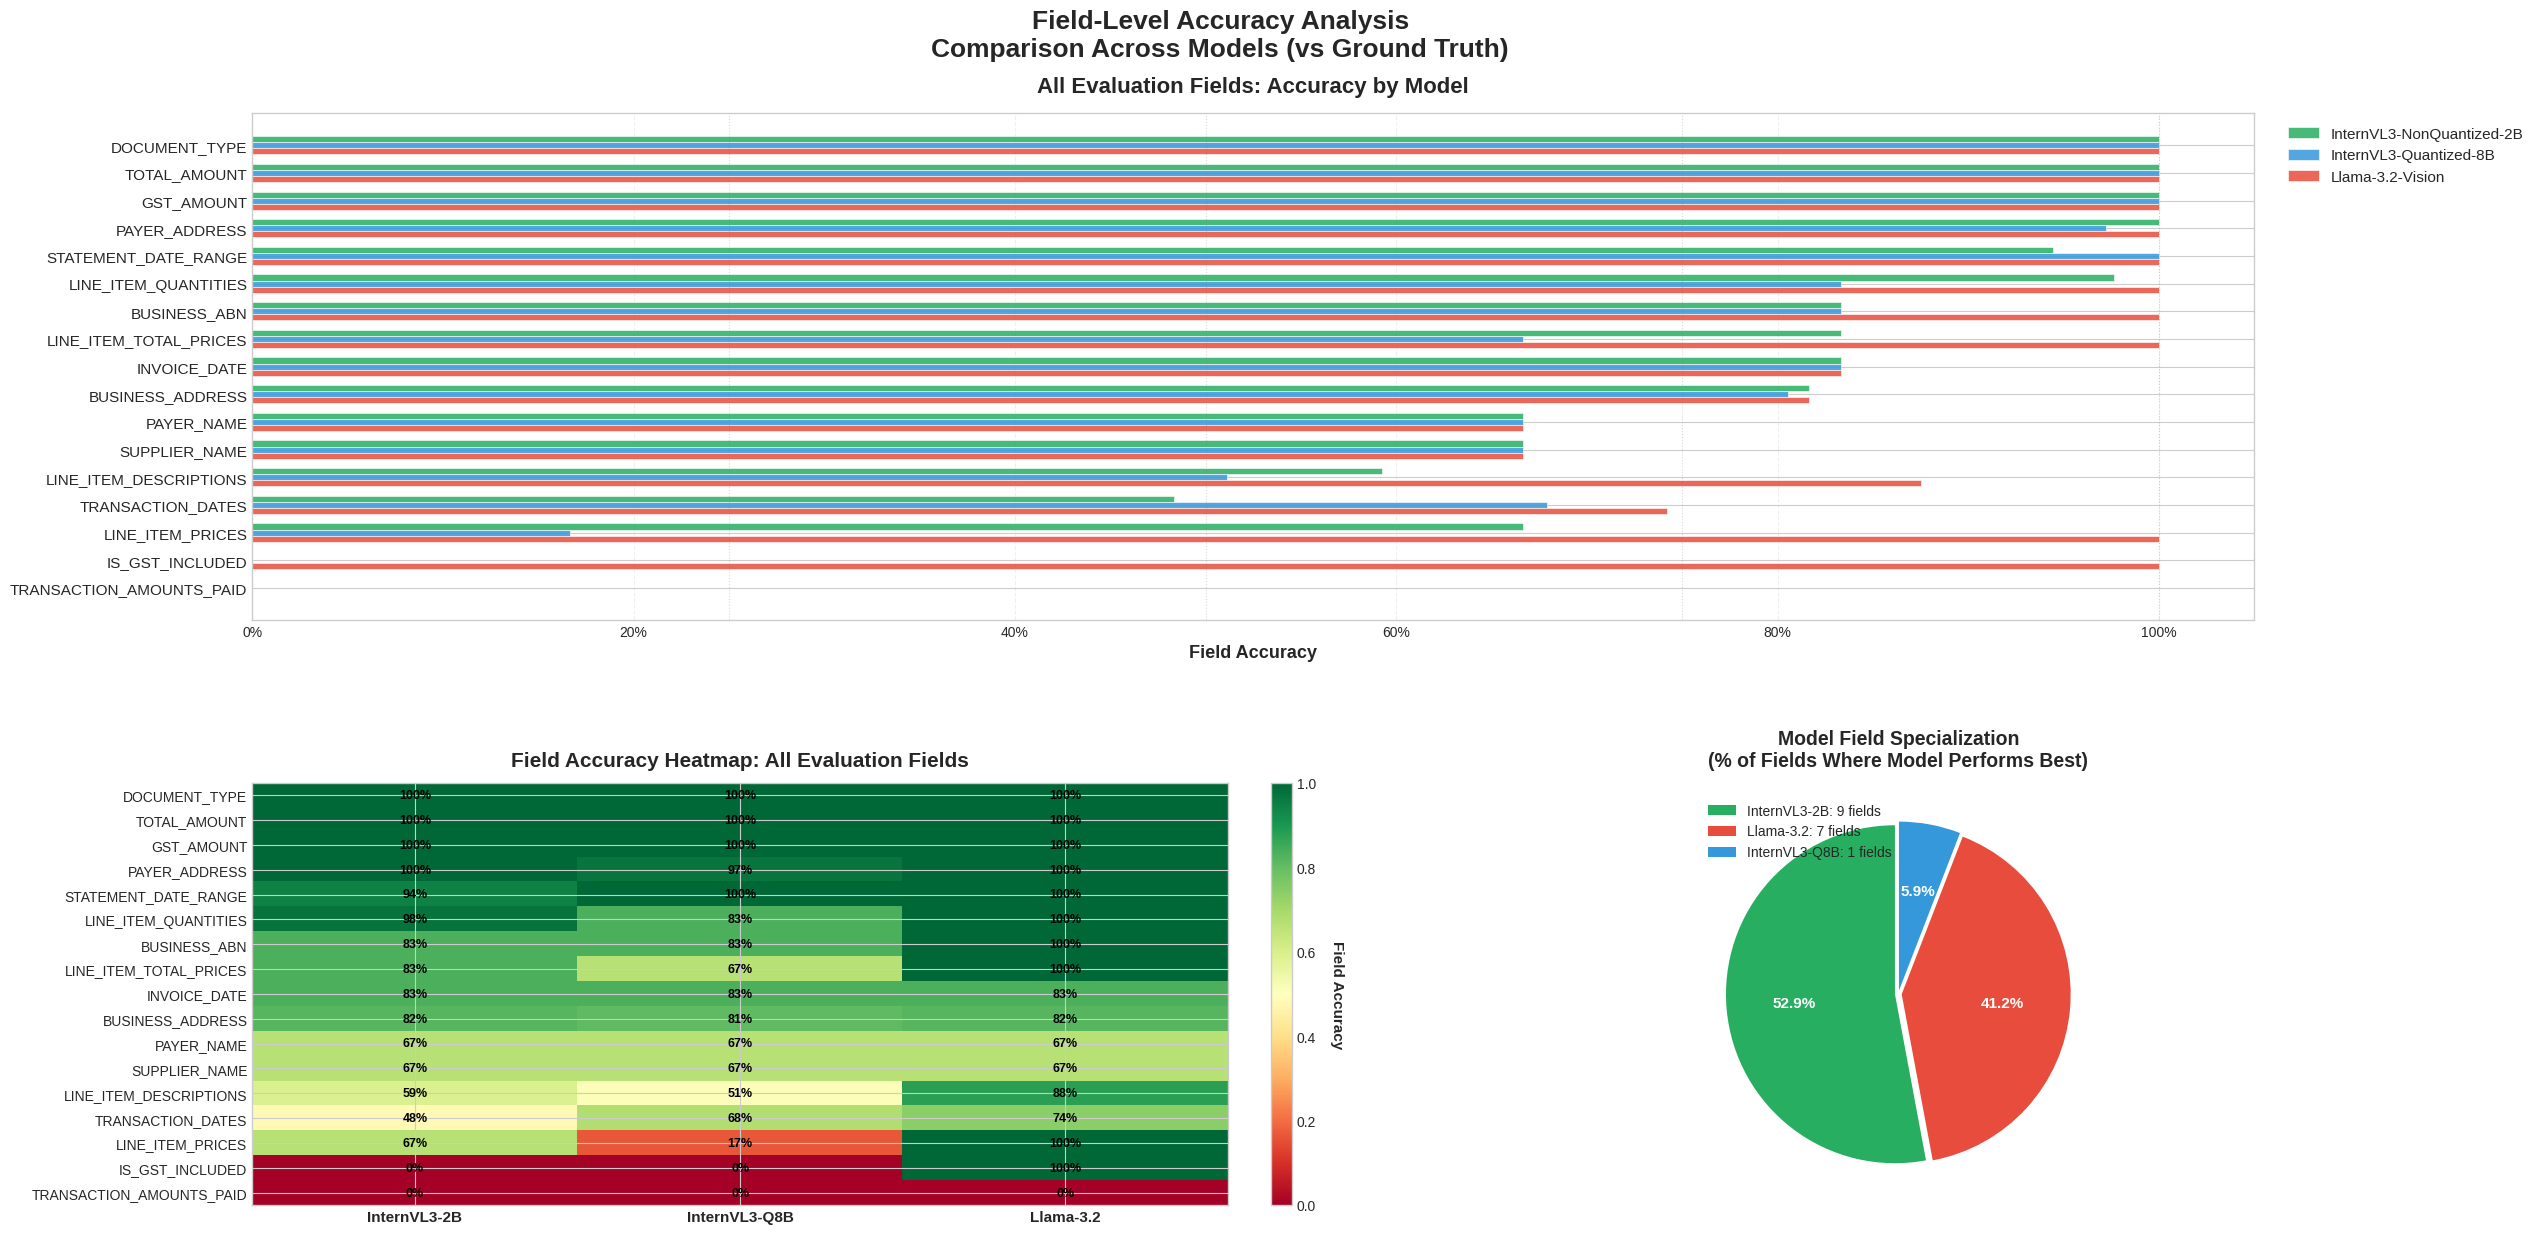

In [9]:
# Cell 12

def create_field_level_visualizations(field_df: pd.DataFrame, field_performance: pd.DataFrame, save_path: str = None):
    """
    Create comprehensive field-level performance visualizations.
    
    Args:
        field_df: Raw field-level accuracy data
        field_performance: Analyzed field performance comparison
        save_path: Optional path to save visualization
    """
    if field_df.empty or field_performance.empty:
        rprint("[red]❌ Cannot create field visualizations - no data available[/red]")
        return
    
    # Create figure with improved spacing
    fig = plt.figure(figsize=(22, 13))
    gs = fig.add_gridspec(2, 2, height_ratios=[1.2, 1], width_ratios=[1.5, 1], 
                          hspace=0.35, wspace=0.25, top=0.90, bottom=0.06, left=0.06, right=0.97)
    
    # Color scheme matching main dashboard
    model_order = ['Llama-3.2-Vision', 'InternVL3-Quantized-8B', 'InternVL3-NonQuantized-2B']
    fixed_colors = {
        'Llama-3.2-Vision': '#E74C3C',
        'InternVL3-Quantized-8B': '#3498DB',
        'InternVL3-NonQuantized-2B': '#27AE60'
    }
    
    # Get available models
    available_models = field_df['model'].unique()
    models = [model for model in model_order if model in available_models]
    model_colors = {model: fixed_colors[model] for model in models if model in fixed_colors}
    
    # 1. Field Accuracy Comparison (Horizontal Bar Chart) - IMPROVED
    ax1 = fig.add_subplot(gs[0, :])
    
    # Get all evaluation fields by average accuracy
    all_eval_fields = field_performance
    model_cols = [col for col in all_eval_fields.columns if col in models]
    
    y_pos = np.arange(len(all_eval_fields))
    bar_height = 0.22
    
    # Create bars with better spacing
    for idx, model in enumerate(model_cols):
        offset = (idx - len(model_cols)/2 + 0.5) * bar_height
        bars = ax1.barh(y_pos + offset, all_eval_fields[model], bar_height, 
                label=model, color=model_colors.get(model, '#999999'), alpha=0.85, edgecolor='white', linewidth=0.5)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(all_eval_fields.index, fontsize=11)
    ax1.invert_yaxis()  # Match heatmap ordering (top-to-bottom)
    ax1.set_xlabel('Field Accuracy', fontsize=13, fontweight='bold')
    ax1.set_title('All Evaluation Fields: Accuracy by Model', fontsize=16, fontweight='bold', pad=15)
    
    # Improved legend placement - outside plot area to avoid occlusion
    ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=11, framealpha=0.98, edgecolor='gray', shadow=True)
    ax1.grid(True, alpha=0.3, axis='x', linestyle='--')
    ax1.set_xlim(0, 1.05)
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))
    
    # Add vertical reference lines
    for x in [0.25, 0.5, 0.75, 1.0]:
        ax1.axvline(x=x, color='gray', linestyle=':', alpha=0.3, linewidth=0.8)
    
    # 2. Field Accuracy Heatmap - IMPROVED
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Get all evaluation fields for heatmap (same as bar chart for consistency)
    heatmap_data = field_performance[model_cols]
    
    # Create heatmap with better colors
    im = ax2.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    # Improved tick labels
    ax2.set_xticks(np.arange(len(model_cols)))
    ax2.set_yticks(np.arange(len(heatmap_data)))
    
    # Better label formatting - shorten model names for display
    model_labels = []
    for model in model_cols:
        if model == 'Llama-3.2-Vision':
            model_labels.append('Llama-3.2')
        elif model == 'InternVL3-Quantized-8B':
            model_labels.append('InternVL3-Q8B')
        elif model == 'InternVL3-NonQuantized-2B':
            model_labels.append('InternVL3-2B')
        else:
            model_labels.append(model)
    
    ax2.set_xticklabels(model_labels, rotation=0, ha='center', fontsize=11, fontweight='bold')
    ax2.set_yticklabels(heatmap_data.index, fontsize=10)
    
    # Improved colorbar
    cbar = plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    cbar.set_label('Field Accuracy', rotation=270, labelpad=20, fontsize=11, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)
    
    # Add text annotations with better visibility
    for i in range(len(heatmap_data)):
        for j in range(len(model_cols)):
            value = heatmap_data.iloc[i, j]
            if not np.isnan(value):
                text_color = 'white' if value < 0.0 else 'black'
                ax2.text(j, i, f'{value:.0%}', ha='center', va='center', 
                        color=text_color, fontsize=9, fontweight='bold')
    
    ax2.set_title('Field Accuracy Heatmap: All Evaluation Fields', fontsize=15, fontweight='bold', pad=12)
    
    # 3. Model Specialization Pie Chart - IMPROVED
    ax3 = fig.add_subplot(gs[1, 1])
    
    specialization = field_performance['best_model'].value_counts()
    colors_list = [model_colors.get(model, '#999999') for model in specialization.index]
    
    # Improved pie chart with better labels
    wedges, texts, autotexts = ax3.pie(
        specialization.values,
        labels=None,  # We'll add custom labels
        autopct='%1.1f%%',
        colors=colors_list,
        startangle=90,
        textprops={'fontsize': 11, 'fontweight': 'bold'},
        explode=[0.02] * len(specialization)  # Slight separation
    )
    
    # Make percentage text bold and white
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    # Add custom legend with shortened names
    legend_labels = []
    for model in specialization.index:
        count = specialization[model]
        pct = (count / len(field_performance)) * 100
        if model == 'Llama-3.2-Vision':
            legend_labels.append(f'Llama-3.2: {count} fields')
        elif model == 'InternVL3-Quantized-8B':
            legend_labels.append(f'InternVL3-Q8B: {count} fields')
        elif model == 'InternVL3-NonQuantized-2B':
            legend_labels.append(f'InternVL3-2B: {count} fields')
        else:
            legend_labels.append(f'{model}: {count} fields')
    
    ax3.legend(legend_labels, loc='upper left', fontsize=10, framealpha=0.95, 
               bbox_to_anchor=(0.02, 0.98), edgecolor='gray')
    
    ax3.set_title('Model Field Specialization\n(% of Fields Where Model Performs Best)', 
                 fontsize=14, fontweight='bold', pad=12)
    
    # Overall title - cleaned up
    fig.suptitle('Field-Level Accuracy Analysis\nComparison Across Models (vs Ground Truth)', 
                fontsize=19, fontweight='bold')
    
    # Save the visualization
    if save_path:
        plt.savefig(save_path, dpi=CONFIG['dpi'], bbox_inches='tight', facecolor='white')
        rprint(f"[green]✅ Field-level visualization saved to: {save_path}[/green]")
    
    plt.show()

# Create field-level visualizations
field_viz_timestamp = None
if not field_level_df.empty and 'field_performance' in locals():
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = Path(f"output/visualizations/field_level_accuracy_{timestamp}.png")
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    create_field_level_visualizations(field_level_df, field_performance, str(output_path))
    field_viz_timestamp = timestamp
else:
    rprint("[red]❌ Cannot create field visualizations - no field-level data available[/red]")

## 5. Detailed Performance Analysis

In [10]:
# Cell 14

def analyze_model_strengths(df: pd.DataFrame):
    """
    Analyze and compare model strengths and weaknesses.
    """
    if df.empty:
        return
    
    rprint("\n[bold green]🎯 DETAILED PERFORMANCE ANALYSIS[/bold green]")
    
    # Document type winner analysis
    doc_performance = df.groupby(['document_type', 'model'])['overall_accuracy'].mean().unstack()
    
    rprint("\n[bold blue]📊 Document Type Performance Leaders:[/bold blue]")
    for doc_type in doc_performance.index:
        best_model = doc_performance.loc[doc_type].idxmax()
        best_score = doc_performance.loc[doc_type].max()
        other_model = [m for m in doc_performance.columns if m != best_model][0]
        other_score = doc_performance.loc[doc_type, other_model]
        improvement = best_score - other_score
        
        rprint(f"  • **{doc_type}**: {best_model} leads with {best_score:.1f}% (+{improvement:.1f}% advantage)")
    
    # Speed analysis
    rprint("\n[bold blue]⚡ Processing Speed Analysis:[/bold blue]")
    speed_comparison = df.groupby('model')['processing_time'].agg(['mean', 'min', 'max', 'std'])
    for model in speed_comparison.index:
        stats = speed_comparison.loc[model]
        throughput = 60 / stats['mean']
        rprint(f"  • **{model}**: Avg {stats['mean']:.1f}s ({throughput:.1f} docs/min), Range {stats['min']:.1f}-{stats['max']:.1f}s")
    
    # Consistency analysis
    rprint("\n[bold blue]📈 Consistency Analysis (Lower std dev = more consistent):[/bold blue]")
    consistency = df.groupby('model')['overall_accuracy'].std()
    for model in consistency.index:
        rprint(f"  • **{model}**: ±{consistency[model]:.1f}% standard deviation")
    
    # Efficiency score (accuracy/time ratio)
    rprint("\n[bold blue]💡 Efficiency Score (Accuracy per Second):[/bold blue]")
    df['efficiency_score'] = df['overall_accuracy'] / df['processing_time']
    efficiency = df.groupby('model')['efficiency_score'].mean()
    for model in efficiency.index:
        rprint(f"  • **{model}**: {efficiency[model]:.2f} accuracy points per second")

# Run detailed analysis
if not combined_df.empty:
    analyze_model_strengths(combined_df)
else:
    rprint("[red]❌ Cannot run analysis - no data available[/red]")

🎯 DETAILED PERFORMANCE ANALYSIS

📊 Document Type Performance Leaders:

• **bank_statement**: Llama-3.2-Vision leads with 67.5% (+22.4% advantage)

• **invoice**: Llama-3.2-Vision leads with 96.6% (+12.6% advantage)

• **receipt**: Llama-3.2-Vision leads with 100.0% (+7.1% advantage)

⚡ Processing Speed Analysis:

• **InternVL3-NonQuantized-2B**: Avg 12.3s (4.9 docs/min), Range 6.2-43.6s

• **InternVL3-Quantized-8B**: Avg 41.1s (1.5 docs/min), Range 22.7-106.0s

• **Llama-3.2-Vision**: Avg 11.7s (5.1 docs/min), Range 7.2-30.9s

📈 Consistency Analysis (Lower std dev = more consistent):

• **InternVL3-NonQuantized-2B**: ±22.5% standard deviation

• **InternVL3-Quantized-8B**: ±15.9% standard deviation

• **Llama-3.2-Vision**: ±15.8% standard deviation

💡 Efficiency Score (Accuracy per Second):

• **InternVL3-NonQuantized-2B**: 8.98 accuracy points per second

• **InternVL3-Quantized-8B**: 2.38 accuracy points per second

• **Llama-3.2-Vision**: 9.50 accuracy points per second

### Data Preparation for Confusion Analysis

Load ground truth and prepare batch data for confusion matrix analysis.

In [11]:
# # Cell 16

# Load ground truth as DataFrame for confusion analysis
ground_truth_path = Path(CONFIG['ground_truth_path'])

if not ground_truth_path.exists():
    rprint(f"[red]❌ Ground truth file not found: {ground_truth_path}[/red]")
    ground_truth = pd.DataFrame()
else:
    # Load FULL ground truth first
    ground_truth_full = pd.read_csv(ground_truth_path, dtype=str)
    rprint(f"[dim]  Loaded full ground truth: {len(ground_truth_full)} rows[/dim]")

    # Normalize column name: ground truth uses 'image_name', we need 'image_file'
    if 'image_name' in ground_truth_full.columns and 'image_file' not in ground_truth_full.columns:
        ground_truth_full['image_file'] = ground_truth_full['image_name']
        rprint(f"[dim]  Normalized: 'image_name' → 'image_file'[/dim]")
    elif 'image_file' not in ground_truth_full.columns:
        # Try other possible column names
        possible_names = ['filename', 'file', 'image']
        for col in possible_names:
            if col in ground_truth_full.columns:
                ground_truth_full['image_file'] = ground_truth_full[col]
                rprint(f"[dim]  Normalized: '{col}' → 'image_file'[/dim]")
                break

    # Add image_stem column to ground truth for matching
    ground_truth_full['image_stem'] = ground_truth_full['image_file'].apply(lambda x: Path(x).stem)
    ground_truth = ground_truth_full

# Prepare batch dataframes with consistent naming for confusion analysis
# Use the loaded data from cell 5
llama_batch_df = llama_df.copy() if not llama_df.empty else pd.DataFrame()
internvl_batch_df = internvl3_quantized_df.copy() if not internvl3_quantized_df.empty else pd.DataFrame()
internvl_nq_batch_df = internvl3_non_quantized_df.copy() if not internvl3_non_quantized_df.empty else pd.DataFrame()

# Verify data is available
if llama_batch_df.empty:
    rprint("[yellow]⚠️ Warning: Llama batch data not loaded. Run cell 5 first.[/yellow]")
else:
    rprint(f"[cyan]Llama batch data: {len(llama_batch_df)} rows[/cyan]")
    if 'document_type' in llama_batch_df.columns:
        rprint(f"[dim]  Predicted document types: {llama_batch_df['document_type'].value_counts().to_dict()}[/dim]")

if internvl_batch_df.empty:
    rprint("[yellow]⚠️ Warning: InternVL3-Quantized batch data not loaded. Run cell 5 first.[/yellow]")
else:
    rprint(f"[cyan]InternVL3-Quantized batch data: {len(internvl_batch_df)} rows[/cyan]")
    if 'document_type' in internvl_batch_df.columns:
        rprint(f"[dim]  Predicted document types: {internvl_batch_df['document_type'].value_counts().to_dict()}[/dim]")

if internvl_nq_batch_df.empty:
    rprint("[yellow]⚠️ Warning: InternVL3-NonQuantized batch data not loaded. Run cell 5 first.[/yellow]")
else:
    rprint(f"[cyan]InternVL3-NonQuantized batch data: {len(internvl_nq_batch_df)} rows[/cyan]")
    if 'document_type' in internvl_nq_batch_df.columns:
        rprint(f"[dim]  Predicted document types: {internvl_nq_batch_df['document_type'].value_counts().to_dict()}[/dim]")

if ground_truth.empty:
    rprint("[yellow]⚠️ Warning: Ground truth not loaded. Confusion analysis will not work.[/yellow]")
elif 'image_file' not in ground_truth.columns:
    rprint("[red]❌ Error: Ground truth missing 'image_file' column[/red]")
    rprint(f"[yellow]   Available columns: {list(ground_truth.columns)}[/yellow]")
else:
    rprint(f"[cyan]Ground truth: {len(ground_truth)} rows[/cyan]")

rprint("[green]✅ Data ready for confusion analysis[/green]")



  Loaded full ground truth: 9 rows

Llama batch data: 9 rows

  Predicted document types: {'receipt': 3, 'bank_statement': 3, 'invoice': 3}

InternVL3-Quantized batch data: 9 rows

  Predicted document types: {'receipt': 3, 'bank_statement': 3, 'invoice': 3}

InternVL3-NonQuantized batch data: 9 rows

  Predicted document types: {'receipt': 3, 'bank_statement': 3, 'invoice': 3}

Ground truth: 9 rows

✅ Data ready for confusion analysis

## 5.4 Document Type Confusion Matrix

**Classic confusion matrix showing document type classification accuracy.**

Shows how well each model correctly identifies document types (INVOICE, RECEIPT, BANK_STATEMENT) and where misclassifications occur.

Creating document type confusion matrices for 3 models...

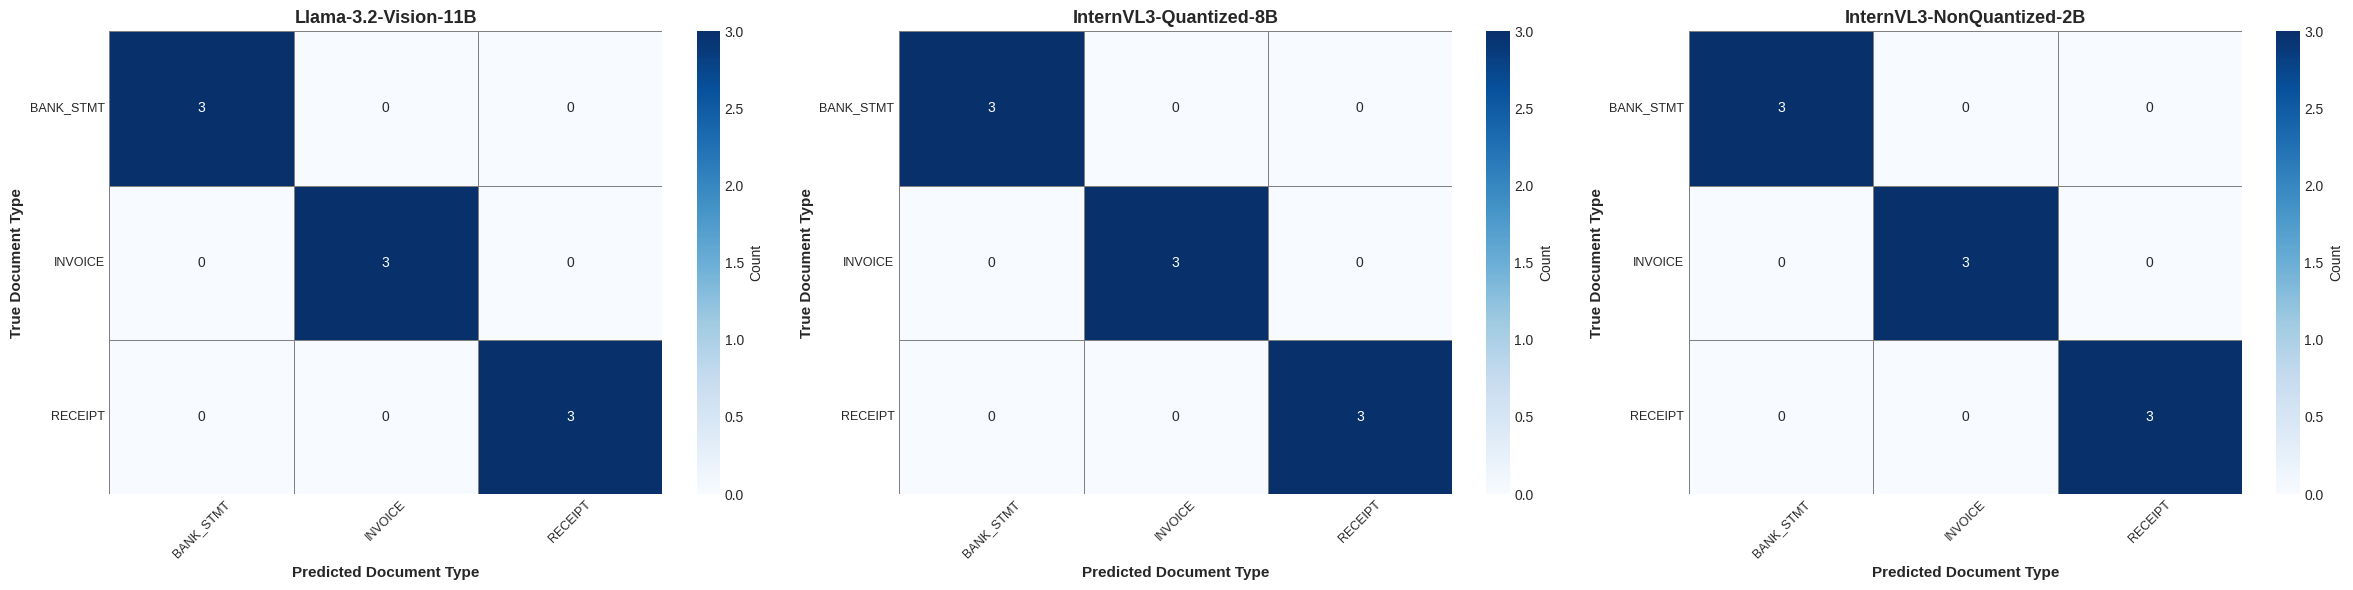

✅ 3-panel document type confusion matrices created

Llama - Document Type Classification Report:

,precision,recall,f1-score,support
BANK_STATEMENT,1.0,1.0,1.0,3.0
INVOICE,1.0,1.0,1.0,3.0
RECEIPT,1.0,1.0,1.0,3.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,9.0
weighted avg,1.0,1.0,1.0,9.0


InternVL3-Quantized - Document Type Classification Report:

,precision,recall,f1-score,support
BANK_STATEMENT,1.0,1.0,1.0,3.0
INVOICE,1.0,1.0,1.0,3.0
RECEIPT,1.0,1.0,1.0,3.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,9.0
weighted avg,1.0,1.0,1.0,9.0


InternVL3-NonQuantized - Document Type Classification Report:

,precision,recall,f1-score,support
BANK_STATEMENT,1.0,1.0,1.0,3.0
INVOICE,1.0,1.0,1.0,3.0
RECEIPT,1.0,1.0,1.0,3.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,9.0
weighted avg,1.0,1.0,1.0,9.0


Document Type Classification Accuracy:

Llama-3.2-Vision-11B: 100.0%

InternVL3-Quantized-8B: 100.0%

InternVL3-NonQuantized-2B: 100.0%

✅ Document type confusion analysis complete for all 3 models

In [12]:
# Cell 18

from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def abbreviate_doctype(name):
    """Shorten long document type names for visualization."""
    abbrev = {
        'COMPULSORY THIRD PARTY PERSONAL INJURY INSURANCE GREEN SLIP CERTIFICATE': 'CTP_INSUR',
        'E-TICKET ITINERARY, RECEIPT AND TAX INVOICE': 'E-TICKET',
        'MOBILE APP SCREENSHOT': 'MOBILE_SS',
        'PAYMENT ADVICE': 'PAYMENT',
        'CRYPTO STATEMENT': 'CRYPTO',
        'TAX INVOICE': 'TAX_INV',
        'INVOICE': 'INVOICE',
        'RECEIPT': 'RECEIPT',
        'BANK_STATEMENT': 'BANK_STMT',
        'NOT_FOUND': 'NOT_FOUND'
    }
    return abbrev.get(name, name[:12])  # Fallback: truncate to 12 chars

def create_doctype_confusion_matrix(df_batch: pd.DataFrame, ground_truth_df: pd.DataFrame, model_name: str):
    """
    Create document type confusion matrix using pandas crosstab.

    Args:
        df_batch: Batch results DataFrame with predicted document types
        ground_truth_df: Ground truth DataFrame with true document types
        model_name: Name of the model

    Returns:
        tuple: (confusion_matrix, classification_report_dict, col_labels, row_labels, y_true, y_pred)
    """
    # Normalize image names (strip extensions) for matching
    # Batch has extensions (.jpeg, .png), ground truth does not
    df_batch['image_stem'] = df_batch['image_file'].apply(lambda x: Path(x).stem)
    ground_truth_df['image_stem'] = ground_truth_df['image_file'].apply(lambda x: Path(x).stem)

    # Merge to align predictions with ground truth using stems
    merged = df_batch.merge(
        ground_truth_df[['image_stem', 'DOCUMENT_TYPE']],
        on='image_stem',
        how='inner',
        suffixes=('_pred', '_true')
    )

    # Get predicted and true document types
    # CRITICAL: Use DOCUMENT_TYPE (extracted field) for predictions
    #           Use DOCUMENT_TYPE from ground truth for true labels (3 types)

    if 'DOCUMENT_TYPE_pred' in merged.columns:
        y_pred = merged['DOCUMENT_TYPE_pred'].fillna('UNKNOWN').astype(str).str.strip().str.upper()
    else:
        y_pred = merged['DOCUMENT_TYPE'].fillna('UNKNOWN').astype(str).str.strip().str.upper()

    if 'DOCUMENT_TYPE_true' in merged.columns:
        y_true = merged['DOCUMENT_TYPE_true'].fillna('UNKNOWN').astype(str).str.strip().str.upper()
    else:
        y_true = merged['DOCUMENT_TYPE'].fillna('UNKNOWN').astype(str).str.strip().str.upper()

    # Use pandas crosstab to create non-square confusion matrix
    # This allows 3 rows (y_true types) × N columns (y_pred types)
    cm_df = pd.crosstab(y_true, y_pred, dropna=False)

    # Convert to numpy array for compatibility with seaborn heatmap
    cm = cm_df.values

    # Get labels and abbreviate them
    labels = [abbreviate_doctype(label) for label in cm_df.columns.tolist()]
    row_labels = [abbreviate_doctype(label) for label in cm_df.index.tolist()]

    # Compute classification report (use original labels)
    report = classification_report(y_true, y_pred, labels=cm_df.columns.tolist(), output_dict=True, zero_division=0)

    return cm, report, labels, row_labels, y_true, y_pred

# Create confusion matrices for all 3 models
rprint("[bold cyan]Creating document type confusion matrices for 3 models...[/bold cyan]")

llama_cm, llama_report, llama_labels, llama_row_labels, llama_y_true, llama_y_pred = create_doctype_confusion_matrix(
    llama_batch_df, ground_truth, 'Llama'
)
internvl_q_cm, internvl_q_report, internvl_q_labels, internvl_q_row_labels, internvl_q_y_true, internvl_q_y_pred = create_doctype_confusion_matrix(
    internvl_batch_df, ground_truth, 'InternVL3-Quantized'
)
internvl_nq_cm, internvl_nq_report, internvl_nq_labels, internvl_nq_row_labels, internvl_nq_y_true, internvl_nq_y_pred = create_doctype_confusion_matrix(
    internvl_nq_batch_df, ground_truth, 'InternVL3-NonQuantized'
)

# Plot confusion matrices in 3-panel layout
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Llama confusion matrix
sns.heatmap(
    llama_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=llama_labels,
    yticklabels=llama_row_labels,
    cbar_kws={'label': 'Count'},
    ax=ax1,
    linewidths=0.5,
    linecolor='gray'
)
ax1.set_title('Llama-3.2-Vision-11B', fontsize=13, fontweight='bold')
ax1.set_xlabel('Predicted Document Type', fontsize=11, fontweight='bold')
ax1.set_ylabel('True Document Type', fontsize=11, fontweight='bold')
ax1.tick_params(axis='x', rotation=45, labelsize=9)
ax1.tick_params(axis='y', rotation=0, labelsize=9)

# InternVL3-Quantized confusion matrix
sns.heatmap(
    internvl_q_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=internvl_q_labels,
    yticklabels=internvl_q_row_labels,
    cbar_kws={'label': 'Count'},
    ax=ax2,
    linewidths=0.5,
    linecolor='gray'
)
ax2.set_title('InternVL3-Quantized-8B', fontsize=13, fontweight='bold')
ax2.set_xlabel('Predicted Document Type', fontsize=11, fontweight='bold')
ax2.set_ylabel('True Document Type', fontsize=11, fontweight='bold')
ax2.tick_params(axis='x', rotation=45, labelsize=9)
ax2.tick_params(axis='y', rotation=0, labelsize=9)

# InternVL3-NonQuantized confusion matrix
sns.heatmap(
    internvl_nq_cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=internvl_nq_labels,
    yticklabels=internvl_nq_row_labels,
    cbar_kws={'label': 'Count'},
    ax=ax3,
    linewidths=0.5,
    linecolor='gray'
)
ax3.set_title('InternVL3-NonQuantized-2B', fontsize=13, fontweight='bold')
ax3.set_xlabel('Predicted Document Type', fontsize=11, fontweight='bold')
ax3.set_ylabel('True Document Type', fontsize=11, fontweight='bold')
ax3.tick_params(axis='x', rotation=45, labelsize=9)
ax3.tick_params(axis='y', rotation=0, labelsize=9)

plt.tight_layout()
plt.savefig(CONFIG['output_dir'].replace('/csv', '/visualizations') + '/doctype_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

rprint("[green]✅ 3-panel document type confusion matrices created[/green]")

# Display classification reports
rprint("\n[bold blue]Llama - Document Type Classification Report:[/bold blue]")
llama_report_df = pd.DataFrame(llama_report).transpose()
display(llama_report_df)

rprint("\n[bold blue]InternVL3-Quantized - Document Type Classification Report:[/bold blue]")
internvl_q_report_df = pd.DataFrame(internvl_q_report).transpose()
display(internvl_q_report_df)

rprint("\n[bold blue]InternVL3-NonQuantized - Document Type Classification Report:[/bold blue]")
internvl_nq_report_df = pd.DataFrame(internvl_nq_report).transpose()
display(internvl_nq_report_df)

# Save classification reports
llama_report_df.to_csv(CONFIG['output_dir'] + '/llama_doctype_classification_report.csv')
internvl_q_report_df.to_csv(CONFIG['output_dir'] + '/internvl3_quantized_doctype_classification_report.csv')
internvl_nq_report_df.to_csv(CONFIG['output_dir'] + '/internvl3_nonquantized_doctype_classification_report.csv')

# Summary accuracy
llama_accuracy = (llama_y_true == llama_y_pred).sum() / len(llama_y_true) * 100
internvl_q_accuracy = (internvl_q_y_true == internvl_q_y_pred).sum() / len(internvl_q_y_true) * 100
internvl_nq_accuracy = (internvl_nq_y_true == internvl_nq_y_pred).sum() / len(internvl_nq_y_true) * 100

rprint("\n[bold blue]Document Type Classification Accuracy:[/bold blue]")
rprint(f"[cyan]Llama-3.2-Vision-11B: {llama_accuracy:.1f}%[/cyan]")
rprint(f"[cyan]InternVL3-Quantized-8B: {internvl_q_accuracy:.1f}%[/cyan]")
rprint(f"[cyan]InternVL3-NonQuantized-2B: {internvl_nq_accuracy:.1f}%[/cyan]")

rprint("[green]✅ Document type confusion analysis complete for all 3 models[/green]")



## 5.5 Field-Level Confusion Analysis

**Confusion matrix showing field extraction status (correct/incorrect/not_found) for each field type.**

This analysis reveals:
- Which fields are most accurately extracted
- Which fields are frequently incorrect vs not found
- Model-specific strengths and weaknesses per field

Creating field-level confusion matrices...

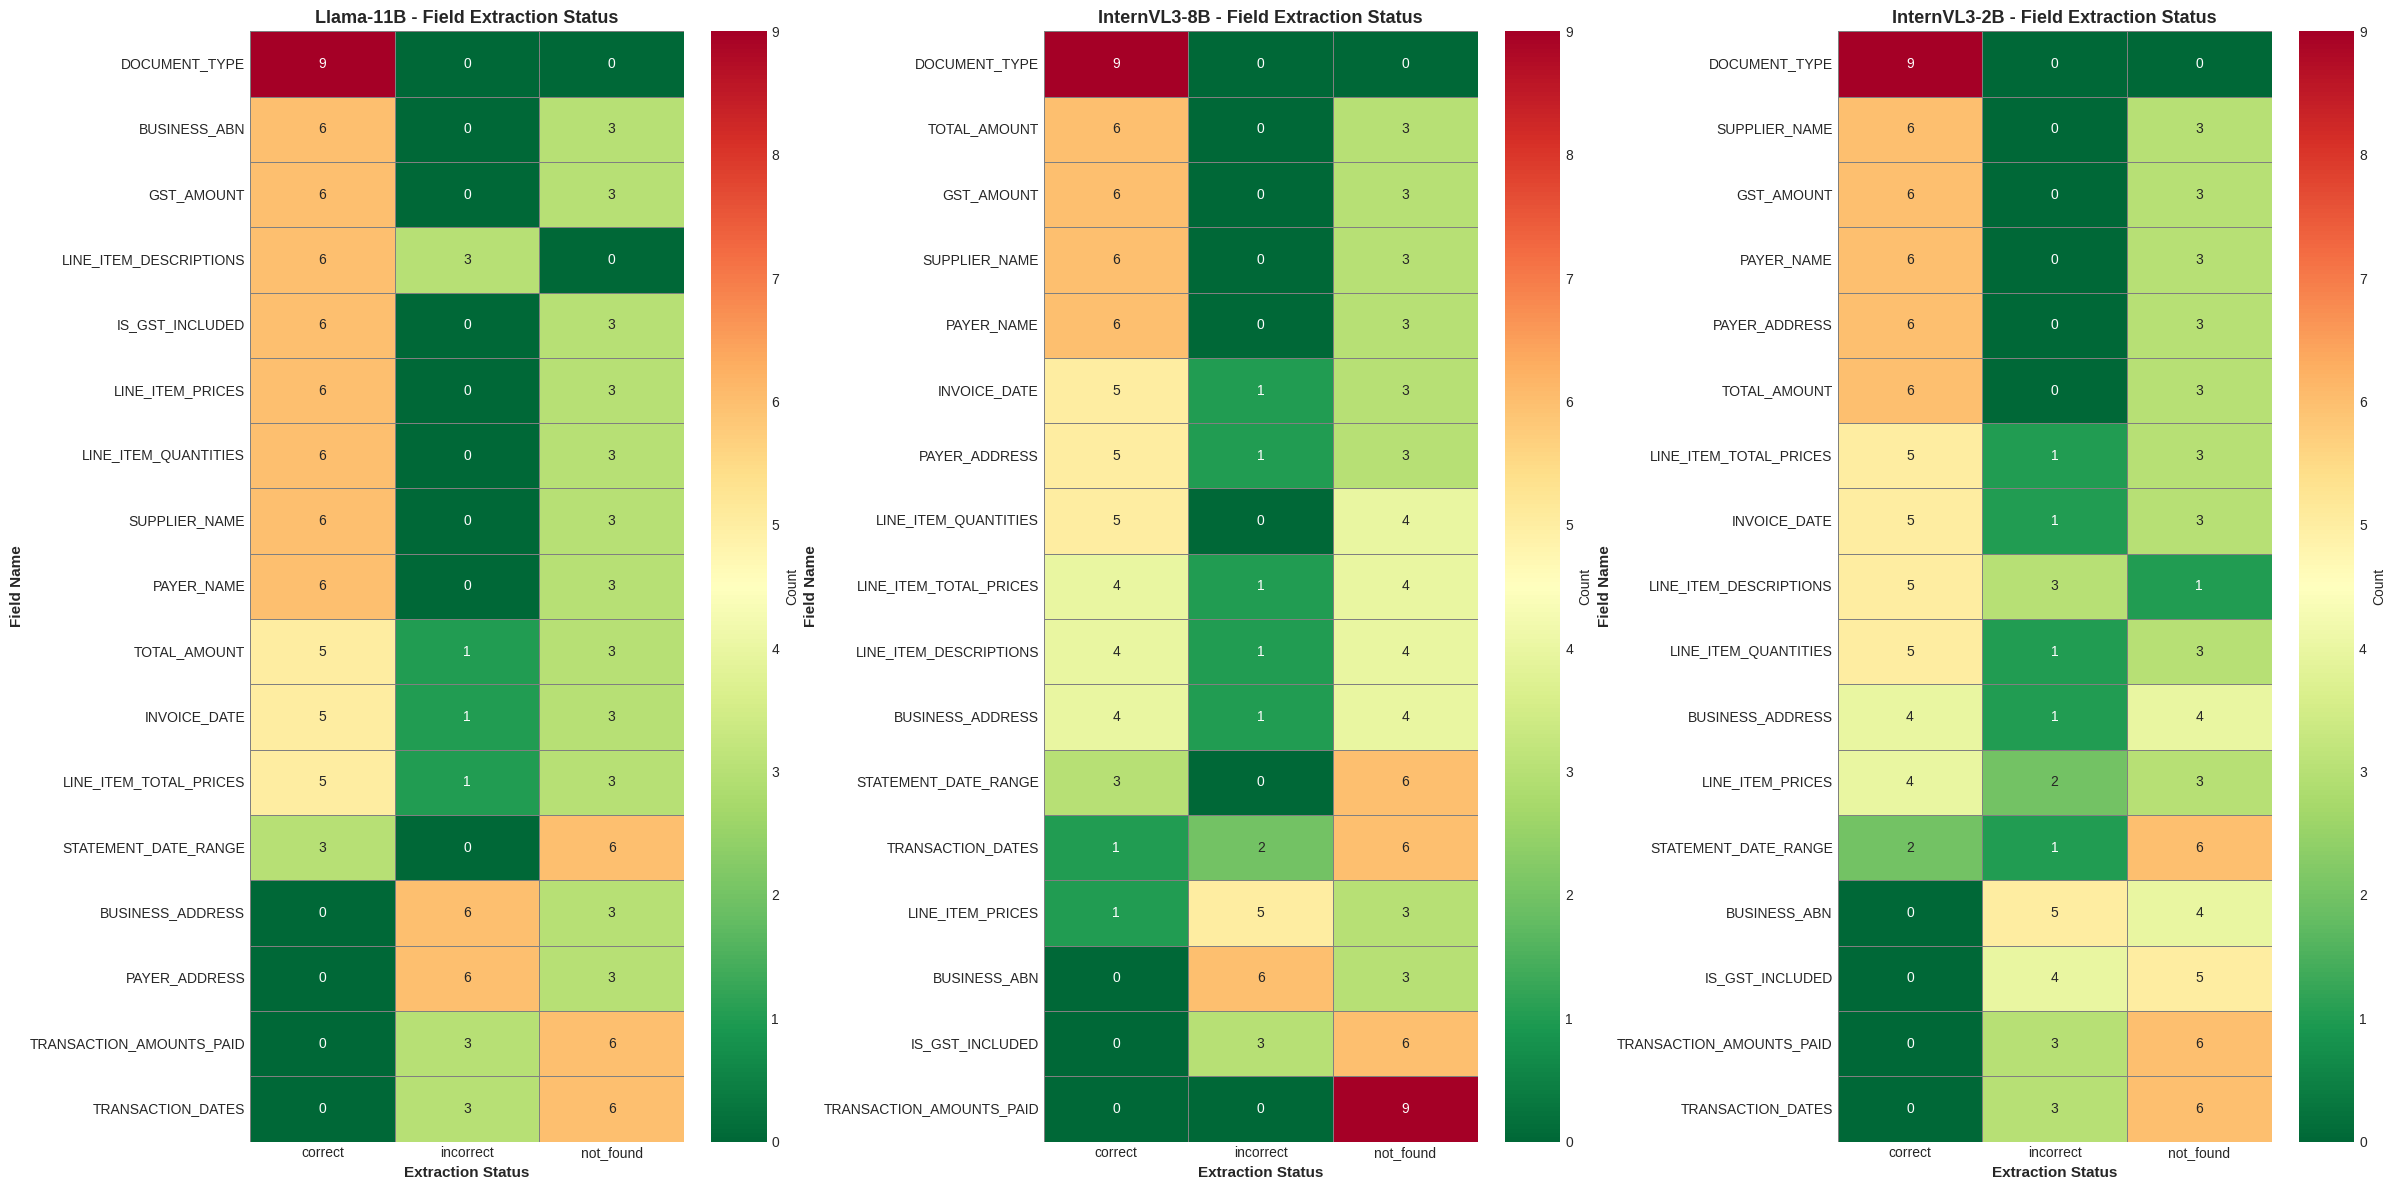

✅ Field-level confusion heatmaps created (3 models)

Field Confusion Summary:

Llama-11B:

Correct: 75/153 (49.0%)

Incorrect: 24/153 (15.7%)

Not Found: 54/153 (35.3%)

InternVL3-8B:

Correct: 65/153 (42.5%)

Incorrect: 21/153 (13.7%)

Not Found: 67/153 (43.8%)

InternVL3-2B:

Correct: 69/153 (45.1%)

Incorrect: 25/153 (16.3%)

Not Found: 59/153 (38.6%)

In [13]:
# Cell 20

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define field columns (from llama_batch.ipynb)
FIELD_COLUMNS = [
    'DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS',
    'PAYER_NAME', 'PAYER_ADDRESS', 'INVOICE_DATE', 'LINE_ITEM_DESCRIPTIONS',
    'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES',
    'IS_GST_INCLUDED', 'GST_AMOUNT', 'TOTAL_AMOUNT', 'STATEMENT_DATE_RANGE',
    'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_PAID'
]

def create_field_confusion_data(df_batch: pd.DataFrame, ground_truth_df: pd.DataFrame, model_name: str) -> pd.DataFrame:
    """
    Create field-level confusion data showing correct/incorrect/not_found status.

    Args:
        df_batch: Batch results DataFrame with extracted field values
        ground_truth_df: Ground truth DataFrame
        model_name: Name of the model

    Returns:
        DataFrame with columns: field, status (correct/incorrect/not_found), count, model
    """
    confusion_data = []

    for field in FIELD_COLUMNS:
        if field not in df_batch.columns or field not in ground_truth_df.columns:
            continue

        correct_count = 0
        incorrect_count = 0
        not_found_count = 0

        # Normalize image names (strip extensions) for matching
        # Batch has extensions (.jpeg, .png), ground truth does not
        if 'image_stem' not in df_batch.columns:
            df_batch['image_stem'] = df_batch['image_file'].apply(lambda x: Path(x).stem)
        if 'image_stem' not in ground_truth_df.columns:
            ground_truth_df['image_stem'] = ground_truth_df['image_file'].apply(lambda x: Path(x).stem)

        # Merge on image_stem to align predictions with ground truth
        merged = df_batch.merge(
            ground_truth_df[['image_stem', field]],
            on='image_stem',
            how='inner',
            suffixes=('_pred', '_true')
        )

        pred_col = f'{field}_pred' if f'{field}_pred' in merged.columns else field
        true_col = f'{field}_true' if f'{field}_true' in merged.columns else field

        for _, row in merged.iterrows():
            pred_val = str(row[pred_col]).strip().upper()
            true_val = str(row[true_col]).strip().upper()

            if pred_val == 'NOT_FOUND' or pred_val == 'NAN' or pred_val == '':
                not_found_count += 1
            elif pred_val == true_val:
                correct_count += 1
            else:
                incorrect_count += 1

        # Add rows for each status
        confusion_data.append({
            'field': field,
            'status': 'correct',
            'count': correct_count,
            'model': model_name
        })
        confusion_data.append({
            'field': field,
            'status': 'incorrect',
            'count': incorrect_count,
            'model': model_name
        })
        confusion_data.append({
            'field': field,
            'status': 'not_found',
            'count': not_found_count,
            'model': model_name
        })

    return pd.DataFrame(confusion_data)

# Create confusion data for all 3 models
rprint("[bold cyan]Creating field-level confusion matrices...[/bold cyan]")

llama_confusion = create_field_confusion_data(llama_batch_df, ground_truth, 'Llama-11B')
internvl_confusion = create_field_confusion_data(internvl_batch_df, ground_truth, 'InternVL3-8B')
internvl_nq_confusion = create_field_confusion_data(internvl_nq_batch_df, ground_truth, 'InternVL3-2B')

# Combine all 3 models
all_confusion = pd.concat([llama_confusion, internvl_confusion, internvl_nq_confusion], ignore_index=True)

# Create pivot table for heatmap visualization
def plot_confusion_heatmap(confusion_df: pd.DataFrame, model_name: str, ax):
    """Plot confusion matrix heatmap for a single model."""
    # Pivot to get fields x status matrix
    pivot = confusion_df[confusion_df['model'] == model_name].pivot(
        index='field',
        columns='status',
        values='count'
    )

    # Reorder columns: correct, incorrect, not_found
    pivot = pivot[['correct', 'incorrect', 'not_found']]

    # Sort by correct count (descending) for better visualization
    pivot = pivot.sort_values('correct', ascending=False)

    # Create heatmap
    sns.heatmap(
        pivot,
        annot=True,
        fmt='g',
        cmap='RdYlGn_r',  # Red for high incorrect/not_found, green for high correct
        cbar_kws={'label': 'Count'},
        ax=ax,
        linewidths=0.5,
        linecolor='gray'
    )

    ax.set_title(f'{model_name} - Field Extraction Status', fontsize=13, fontweight='bold')
    ax.set_xlabel('Extraction Status', fontsize=11, fontweight='bold')
    ax.set_ylabel('Field Name', fontsize=11, fontweight='bold')
    ax.tick_params(axis='y', rotation=0)

# Create 3-panel heatmaps
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 12))

plot_confusion_heatmap(all_confusion, 'Llama-11B', ax1)
plot_confusion_heatmap(all_confusion, 'InternVL3-8B', ax2)
plot_confusion_heatmap(all_confusion, 'InternVL3-2B', ax3)

plt.tight_layout()
plt.savefig(CONFIG['output_dir'].replace('/csv', '/visualizations') + '/field_confusion_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

rprint("[green]✅ Field-level confusion heatmaps created (3 models)[/green]")

# Create summary statistics
rprint("\n[bold blue]Field Confusion Summary:[/bold blue]")
for model in ['Llama-11B', 'InternVL3-8B', 'InternVL3-2B']:
    model_data = all_confusion[all_confusion['model'] == model]
    total = model_data['count'].sum()
    correct = model_data[model_data['status'] == 'correct']['count'].sum()
    incorrect = model_data[model_data['status'] == 'incorrect']['count'].sum()
    not_found = model_data[model_data['status'] == 'not_found']['count'].sum()

    rprint(f"\n[cyan]{model}:[/cyan]")
    rprint(f"  Correct: {correct}/{total} ({correct/total*100:.1f}%)")
    rprint(f"  Incorrect: {incorrect}/{total} ({incorrect/total*100:.1f}%)")
    rprint(f"  Not Found: {not_found}/{total} ({not_found/total*100:.1f}%)")


## 5.6 Per-Field Precision, Recall, and F1 Metrics

**Using sklearn's classification metrics to evaluate per-field extraction performance.**

Metrics explained:
- **Precision**: Of all predicted values, what % were correct?
- **Recall**: Of all ground truth values, what % were correctly extracted?
- **F1 Score**: Harmonic mean of precision and recall
- **Support**: Number of occurrences of each field in ground truth

Computing per-field precision/recall/F1 metrics...

Per-Field Metrics Comparison:

,field,precision,recall,f1_score,accuracy,support,model
35,BUSINESS_ABN,0.000000,0.000000,0.000000,0.333333,9,InternVL3-2B
18,BUSINESS_ABN,0.000000,0.000000,0.000000,0.333333,9,InternVL3-8B
1,BUSINESS_ABN,1.000000,1.000000,1.000000,1.000000,9,Llama-11B
37,BUSINESS_ADDRESS,0.800000,0.800000,0.800000,0.777778,9,InternVL3-2B
20,BUSINESS_ADDRESS,0.800000,0.800000,0.800000,0.777778,9,InternVL3-8B
3,BUSINESS_ADDRESS,0.000000,0.000000,0.000000,0.333333,9,Llama-11B
34,DOCUMENT_TYPE,1.000000,1.000000,1.000000,1.000000,9,InternVL3-2B
17,DOCUMENT_TYPE,1.000000,1.000000,1.000000,1.000000,9,InternVL3-8B
0,DOCUMENT_TYPE,1.000000,1.000000,1.000000,1.000000,9,Llama-11B
46,GST_AMOUNT,1.000000,1.000000,1.000000,1.000000,9,InternVL3-2B


✅ Metrics saved to: /home/jovyan/nfs_share/tod/LMM_POC/output/csv/per_field_metrics.csv

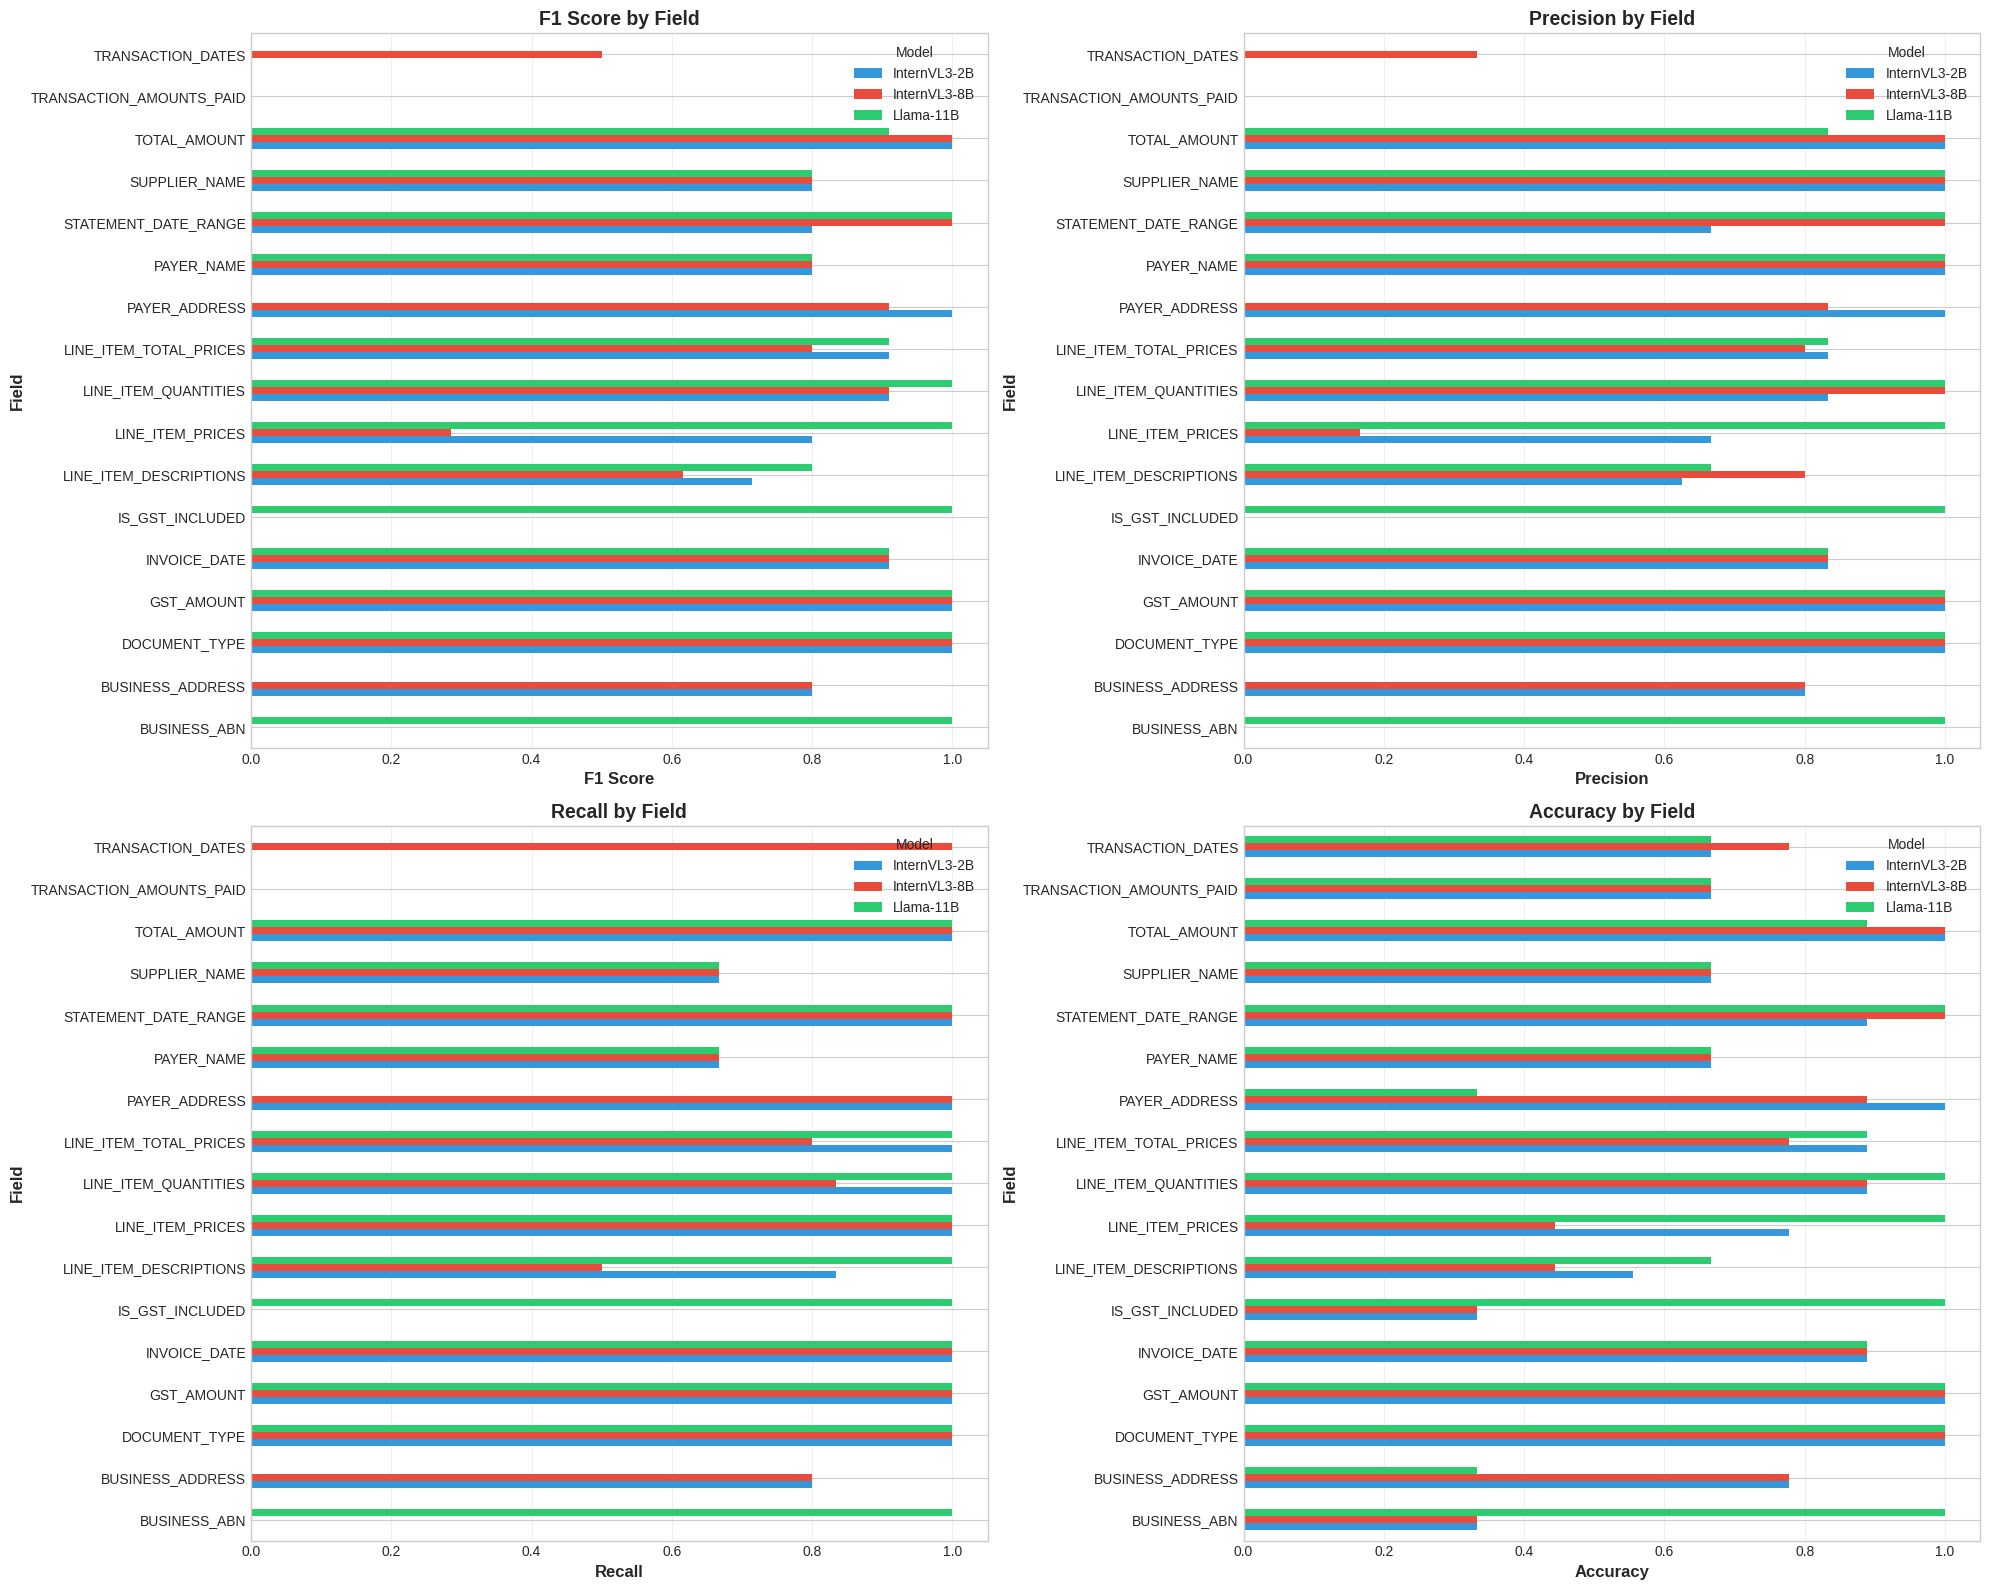

✅ Per-field metrics visualizations created (3 models)

Model Performance Summary:

,precision,recall,f1_score,accuracy
model,,,,
InternVL3-2B,0.6623,0.7039,0.6730,0.7647
InternVL3-8B,0.6804,0.7216,0.6664,0.7386
Llama-11B,0.7157,0.7255,0.7134,0.8039


In [14]:
# Cell 22

from sklearn.metrics import classification_report, precision_recall_fscore_support
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compute_per_field_metrics(df_batch: pd.DataFrame, ground_truth_df: pd.DataFrame, model_name: str) -> pd.DataFrame:
    """
    Compute precision, recall, F1 for each field using sklearn.

    Treats field extraction as a multi-class classification problem where:
    - Each unique field value is a class
    - 'NOT_FOUND' is treated as a special class

    Args:
        df_batch: Batch results DataFrame with extracted field values
        ground_truth_df: Ground truth DataFrame
        model_name: Name of the model

    Returns:
        DataFrame with columns: field, precision, recall, f1, support, model
    """
    metrics_data = []

    for field in FIELD_COLUMNS:
        if field not in df_batch.columns or field not in ground_truth_df.columns:
            continue

        # Normalize image names (strip extensions) for matching
        # Batch has extensions (.jpeg, .png), ground truth does not
        if 'image_stem' not in df_batch.columns:
            df_batch['image_stem'] = df_batch['image_file'].apply(lambda x: Path(x).stem)
        if 'image_stem' not in ground_truth_df.columns:
            ground_truth_df['image_stem'] = ground_truth_df['image_file'].apply(lambda x: Path(x).stem)

        # Merge on image_stem to align predictions with ground truth
        merged = df_batch.merge(
            ground_truth_df[['image_stem', field]],
            on='image_stem',
            how='inner',
            suffixes=('_pred', '_true')
        )

        pred_col = f'{field}_pred' if f'{field}_pred' in merged.columns else field
        true_col = f'{field}_true' if f'{field}_true' in merged.columns else field

        # Clean and normalize values
        y_true = merged[true_col].fillna('NOT_FOUND').astype(str).str.strip().str.upper()
        y_pred = merged[pred_col].fillna('NOT_FOUND').astype(str).str.strip().str.upper()

        # Skip if no valid data
        if len(y_true) == 0:
            continue

        # Compute binary metrics: correct vs incorrect (treating NOT_FOUND as incorrect)
        y_true_binary = y_true
        y_pred_binary = y_pred

        # Calculate exact match accuracy
        matches = (y_true_binary == y_pred_binary).sum()
        total = len(y_true_binary)
        accuracy = matches / total if total > 0 else 0

        # For precision/recall, we treat it as binary: correct extraction vs not
        # This is more meaningful than multi-class for field extraction
        correct_mask = (y_pred_binary == y_true_binary) & (y_pred_binary != 'NOT_FOUND')

        # True positives: predicted correctly (and not NOT_FOUND)
        tp = correct_mask.sum()

        # False positives: predicted incorrectly (but not NOT_FOUND)
        fp = ((y_pred_binary != y_true_binary) & (y_pred_binary != 'NOT_FOUND')).sum()

        # False negatives: failed to extract (predicted NOT_FOUND when ground truth exists)
        fn = ((y_pred_binary == 'NOT_FOUND') & (y_true_binary != 'NOT_FOUND')).sum()

        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics_data.append({
            'field': field,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'accuracy': accuracy,
            'support': total,
            'model': model_name
        })

    return pd.DataFrame(metrics_data)

# Compute metrics for all 3 models
rprint("[bold cyan]Computing per-field precision/recall/F1 metrics...[/bold cyan]")

llama_metrics = compute_per_field_metrics(llama_batch_df, ground_truth, 'Llama-11B')
internvl_metrics = compute_per_field_metrics(internvl_batch_df, ground_truth, 'InternVL3-8B')
internvl_nq_metrics = compute_per_field_metrics(internvl_nq_batch_df, ground_truth, 'InternVL3-2B')

# Combine all 3 models
all_metrics = pd.concat([llama_metrics, internvl_metrics, internvl_nq_metrics], ignore_index=True)

# Display metrics table
rprint("\n[bold blue]Per-Field Metrics Comparison:[/bold blue]")
display(all_metrics.sort_values(['field', 'model']))

# Save to CSV
metrics_csv_path = CONFIG['output_dir'] + '/per_field_metrics.csv'
all_metrics.to_csv(metrics_csv_path, index=False)
rprint(f"[green]✅ Metrics saved to: {metrics_csv_path}[/green]")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Colors for 3 models: Llama (blue), InternVL3-8B (red), InternVL3-2B (green)
model_colors = ['#3498db', '#e74c3c', '#2ecc71']

# Plot 1: F1 Score comparison
ax1 = axes[0, 0]
pivot_f1 = all_metrics.pivot(index='field', columns='model', values='f1_score')
pivot_f1.plot(kind='barh', ax=ax1, color=model_colors)
ax1.set_title('F1 Score by Field', fontsize=14, fontweight='bold')
ax1.set_xlabel('F1 Score', fontsize=12, fontweight='bold')
ax1.set_ylabel('Field', fontsize=12, fontweight='bold')
ax1.legend(title='Model')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Precision comparison
ax2 = axes[0, 1]
pivot_precision = all_metrics.pivot(index='field', columns='model', values='precision')
pivot_precision.plot(kind='barh', ax=ax2, color=model_colors)
ax2.set_title('Precision by Field', fontsize=14, fontweight='bold')
ax2.set_xlabel('Precision', fontsize=12, fontweight='bold')
ax2.set_ylabel('Field', fontsize=12, fontweight='bold')
ax2.legend(title='Model')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Recall comparison
ax3 = axes[1, 0]
pivot_recall = all_metrics.pivot(index='field', columns='model', values='recall')
pivot_recall.plot(kind='barh', ax=ax3, color=model_colors)
ax3.set_title('Recall by Field', fontsize=14, fontweight='bold')
ax3.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax3.set_ylabel('Field', fontsize=12, fontweight='bold')
ax3.legend(title='Model')
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Accuracy comparison
ax4 = axes[1, 1]
pivot_accuracy = all_metrics.pivot(index='field', columns='model', values='accuracy')
pivot_accuracy.plot(kind='barh', ax=ax4, color=model_colors)
ax4.set_title('Accuracy by Field', fontsize=14, fontweight='bold')
ax4.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax4.set_ylabel('Field', fontsize=12, fontweight='bold')
ax4.legend(title='Model')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(CONFIG['output_dir'].replace('/csv', '/visualizations') + '/per_field_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

rprint("[green]✅ Per-field metrics visualizations created (3 models)[/green]")

# Summary statistics
rprint("\n[bold blue]Model Performance Summary:[/bold blue]")
summary_stats = all_metrics.groupby('model').agg({
    'precision': 'mean',
    'recall': 'mean',
    'f1_score': 'mean',
    'accuracy': 'mean'
}).round(4)
display(summary_stats)


## 5.7 Hallucination Analysis

**Purpose**: Measure how often models invent values for fields that don't exist (NOT_FOUND in ground truth).

**Key Metrics**:
- **Hallucination Rate**: Percentage of NOT_FOUND fields where model extracted a value
- **False Positive Rate (FPR)**: FP / (FP + TN) on NOT_FOUND fields
- **Per-Field Hallucination**: Which fields are most hallucinated
- **Per-Document Hallucination**: Distribution of hallucination rates across documents

**Context**: From the accuracy paradox:
- Low accuracy + high F1 → High hallucination (Llama)
- High accuracy + low F1 → Low hallucination (InternVL3)


Analyzing hallucination rates for all models...

DEBUG Llama-11B: total_hallucinations=0, total_not_found_fields=48, overall_rate=0.00%

DEBUG InternVL3-8B: total_hallucinations=0, total_not_found_fields=48, overall_rate=0.00%

DEBUG InternVL3-2B: total_hallucinations=0, total_not_found_fields=48, overall_rate=0.00%

Hallucination Summary:

,Model,Hallucination Rate,Correct NOT_FOUND Rate,Total Hallucinations,Total Opportunities,Mean Doc Hallucination,Std Dev
0,Llama-11B,0.0%,100.0%,0,48,0.0%,0.0%
1,InternVL3-8B,0.0%,100.0%,0,48,0.0%,0.0%
2,InternVL3-2B,0.0%,100.0%,0,48,0.0%,0.0%


Interpretation:

Hallucination Rate = % of NOT_FOUND fields where model invented a value

Correct NOT_FOUND Rate = % of NOT_FOUND fields correctly identified

Higher hallucination = More aggressive extraction (high recall, low accuracy)

Lower hallucination = More conservative extraction (low recall, high accuracy)

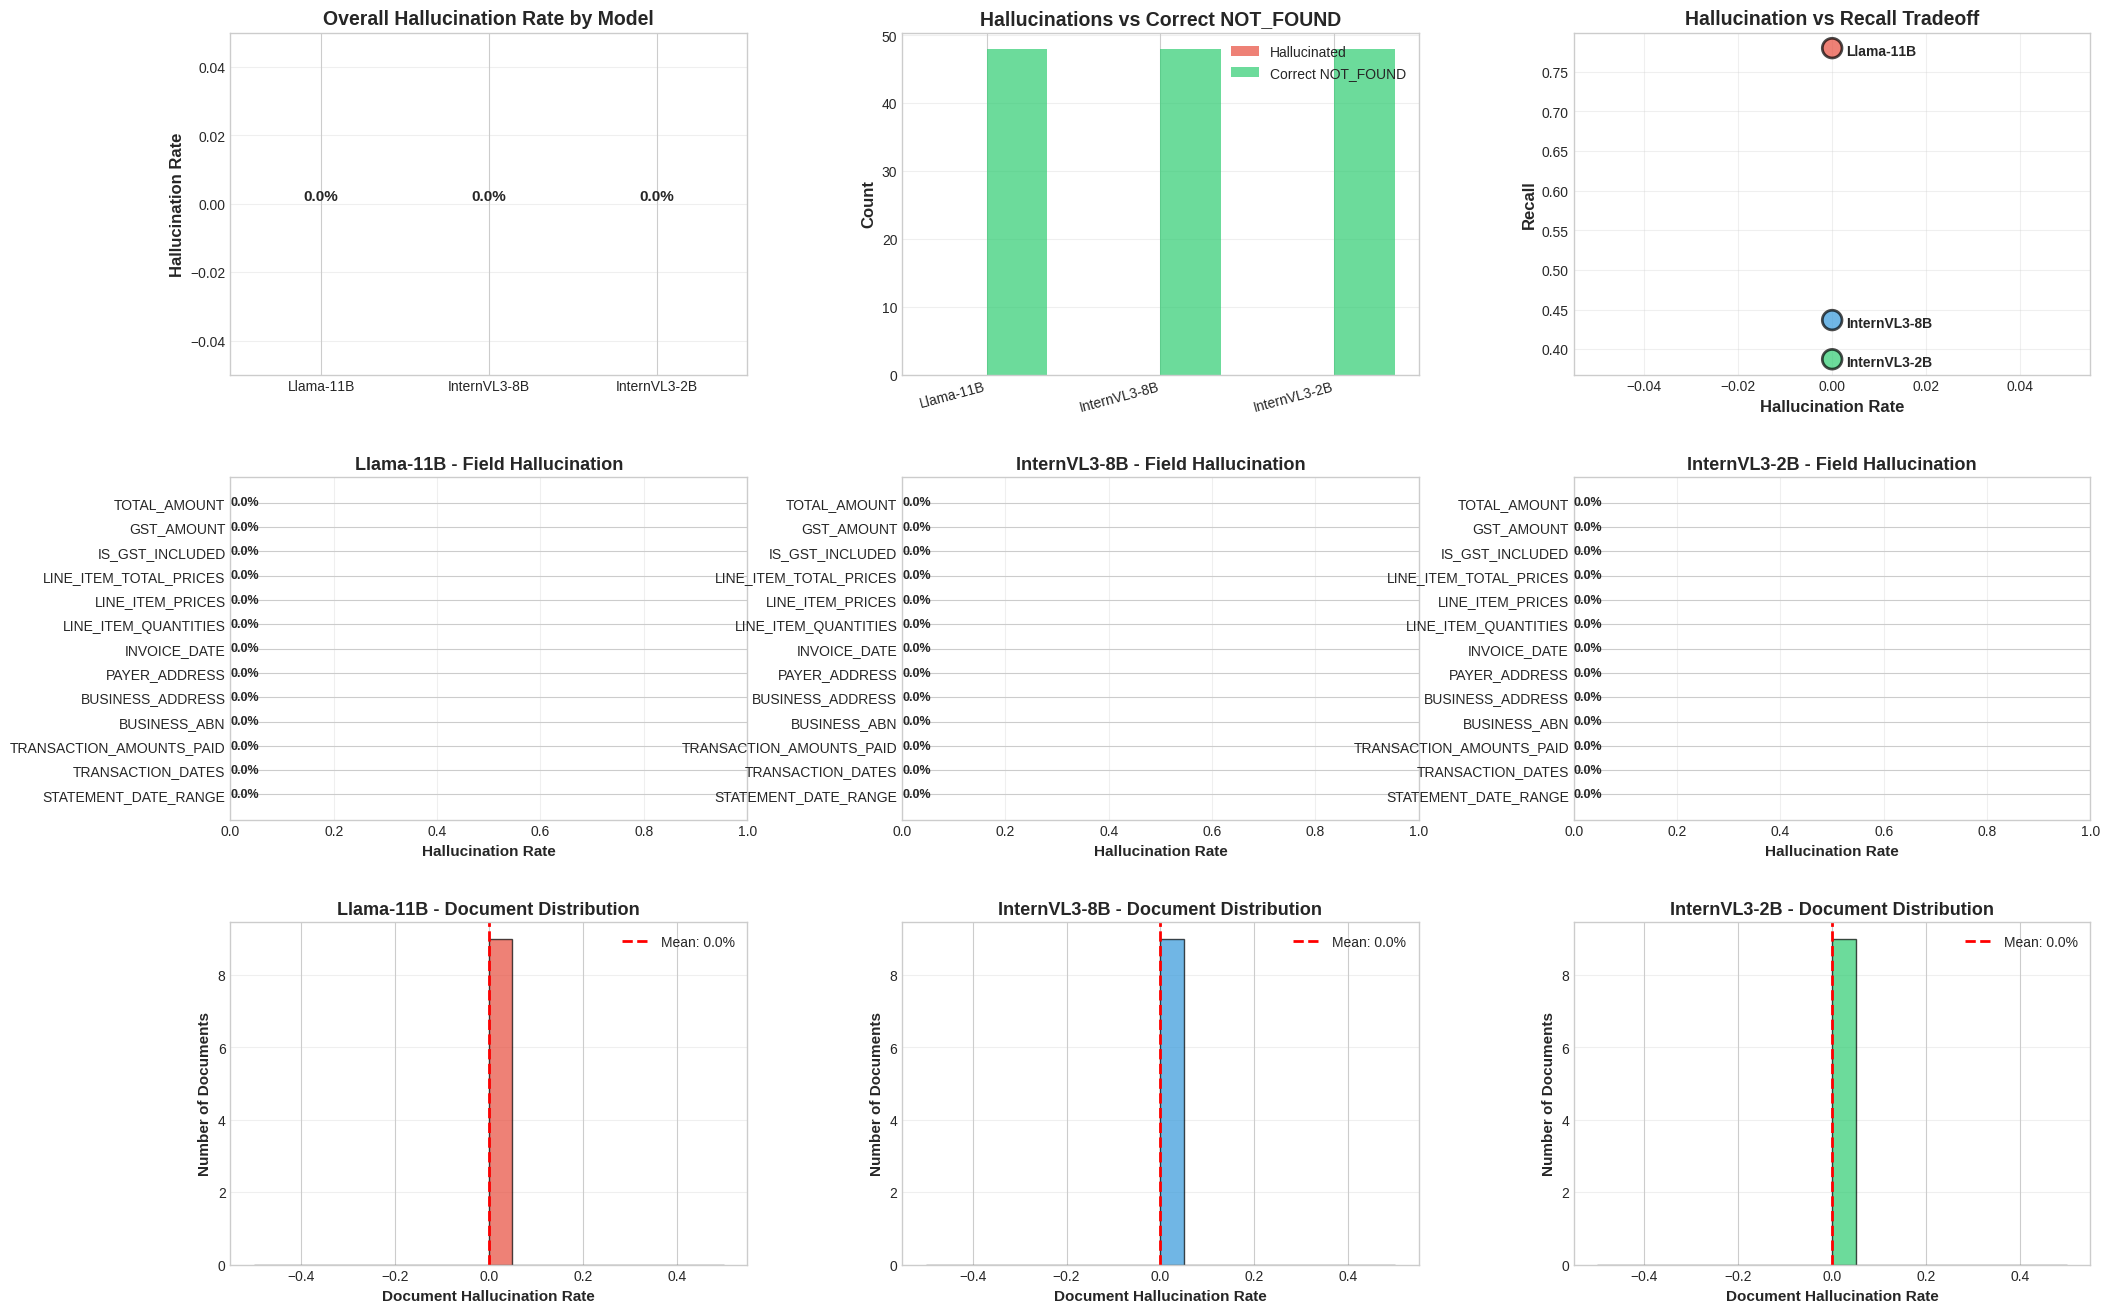

✅ Hallucination analysis complete (9 visualizations created)

💾 Saved: visualizations/hallucination_analysis.png

Key Insights:

🔴 Highest hallucination: Llama-11B (0.0%)

🟢 Lowest hallucination: Llama-11B (0.0%)

Most Hallucinated Fields (avg across models):

• STATEMENT_DATE_RANGE: 0.0%

• TRANSACTION_DATES: 0.0%

• TRANSACTION_AMOUNTS_PAID: 0.0%

• BUSINESS_ABN: 0.0%

• BUSINESS_ADDRESS: 0.0%

In [15]:
#Cell 24

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def comprehensive_hallucination_analysis(model_df, ground_truth_df, model_name):
    """
    Complete hallucination analysis for a model.
    
    Hallucination = Model extracts value when ground truth is NOT_FOUND
    """
    
    # Normalize image names for matching
    if 'image_stem' not in model_df.columns:
        model_df['image_stem'] = model_df['image_file'].apply(lambda x: Path(x).stem)
    if 'image_stem' not in ground_truth_df.columns:
        ground_truth_df['image_stem'] = ground_truth_df['image_file'].apply(lambda x: Path(x).stem)
    
    # Merge to align predictions with ground truth
    merged = model_df.merge(
        ground_truth_df,
        on='image_stem',
        how='inner',
        suffixes=('_pred', '_true')
    )
    
    total_hallucinations = 0
    total_not_found_fields = 0
    total_correct_not_found = 0
    
    field_hallucination = {}
    doc_hallucination_scores = []
    
    for idx in range(len(merged)):
        doc_hallucinations = 0
        doc_not_found = 0
        doc_correct_not_found = 0
        
        for field in FIELD_COLUMNS:
            # SKIP excluded fields
            if field in ['TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']:
                continue
            
            # Get column names (handle suffix)
            true_col = f'{field}_true' if f'{field}_true' in merged.columns else field
            pred_col = f'{field}_pred' if f'{field}_pred' in merged.columns else field
            
            if true_col not in merged.columns or pred_col not in merged.columns:
                continue
            
            gt_val = str(merged.loc[idx, true_col]).strip().upper()
            pred_val = str(merged.loc[idx, pred_col]).strip().upper()
            
            if gt_val in ['NOT_FOUND', 'NAN', '']:
                doc_not_found += 1
                total_not_found_fields += 1
                
                if pred_val not in ['NOT_FOUND', 'NAN', '']:
                    # HALLUCINATION DETECTED
                    doc_hallucinations += 1
                    total_hallucinations += 1
                    
                    # Track per-field
                    if field not in field_hallucination:
                        field_hallucination[field] = {'hallucinated': 0, 'not_found_total': 0}
                    field_hallucination[field]['hallucinated'] += 1
                    field_hallucination[field]['not_found_total'] += 1
                else:
                    # Correctly said NOT_FOUND
                    doc_correct_not_found += 1
                    total_correct_not_found += 1
                    
                    if field not in field_hallucination:
                        field_hallucination[field] = {'hallucinated': 0, 'not_found_total': 0}
                    field_hallucination[field]['not_found_total'] += 1
        
        # Document-level hallucination rate
        doc_rate = doc_hallucinations / doc_not_found if doc_not_found > 0 else 0
        doc_hallucination_scores.append({
            'rate': doc_rate,
            'hallucinated_count': doc_hallucinations,
            'not_found_count': doc_not_found
        })
    
    # Calculate overall rates
    overall_rate = total_hallucinations / total_not_found_fields if total_not_found_fields > 0 else 0
    
    # DEBUG: Print hallucination calculations
    rprint(f"[yellow]DEBUG {model_name}: total_hallucinations={total_hallucinations}, total_not_found_fields={total_not_found_fields}, overall_rate={overall_rate:.2%}[/yellow]")
    
    correct_not_found_rate = total_correct_not_found / total_not_found_fields if total_not_found_fields > 0 else 0
    
    # Per-field hallucination rates
    field_rates = {}
    for field, data in field_hallucination.items():
        if data['not_found_total'] > 0:
            field_rates[field] = {
                'hallucination_rate': data['hallucinated'] / data['not_found_total'],
                'hallucinated_count': data['hallucinated'],
                'opportunities': data['not_found_total']
            }
    
    return {
        'model': model_name,
        'overall_hallucination_rate': overall_rate,
        'correct_not_found_rate': correct_not_found_rate,
        'total_hallucinations': total_hallucinations,
        'total_correct_not_found': total_correct_not_found,
        'total_not_found_opportunities': total_not_found_fields,
        'field_hallucination': field_rates,
        'document_hallucination_scores': doc_hallucination_scores,
        'mean_doc_hallucination': np.mean([d['rate'] for d in doc_hallucination_scores]),
        'std_doc_hallucination': np.std([d['rate'] for d in doc_hallucination_scores])
    }

# Run hallucination analysis for all 3 models
rprint("[bold cyan]Analyzing hallucination rates for all models...[/bold cyan]")

llama_hallucination = comprehensive_hallucination_analysis(
    llama_df, ground_truth, 'Llama-11B'
)

internvl_hallucination = comprehensive_hallucination_analysis(
    internvl3_quantized_df, ground_truth, 'InternVL3-8B'
)

internvl_nq_hallucination = comprehensive_hallucination_analysis(
    internvl3_non_quantized_df, ground_truth, 'InternVL3-2B'
)

# Create summary table
hallucination_summary = pd.DataFrame([
    {
        'Model': llama_hallucination['model'],
        'Hallucination Rate': f"{llama_hallucination['overall_hallucination_rate']:.1%}",
        'Correct NOT_FOUND Rate': f"{llama_hallucination['correct_not_found_rate']:.1%}",
        'Total Hallucinations': llama_hallucination['total_hallucinations'],
        'Total Opportunities': llama_hallucination['total_not_found_opportunities'],
        'Mean Doc Hallucination': f"{llama_hallucination['mean_doc_hallucination']:.1%}",
        'Std Dev': f"{llama_hallucination['std_doc_hallucination']:.1%}"
    },
    {
        'Model': internvl_hallucination['model'],
        'Hallucination Rate': f"{internvl_hallucination['overall_hallucination_rate']:.1%}",
        'Correct NOT_FOUND Rate': f"{internvl_hallucination['correct_not_found_rate']:.1%}",
        'Total Hallucinations': internvl_hallucination['total_hallucinations'],
        'Total Opportunities': internvl_hallucination['total_not_found_opportunities'],
        'Mean Doc Hallucination': f"{internvl_hallucination['mean_doc_hallucination']:.1%}",
        'Std Dev': f"{internvl_hallucination['std_doc_hallucination']:.1%}"
    },
    {
        'Model': internvl_nq_hallucination['model'],
        'Hallucination Rate': f"{internvl_nq_hallucination['overall_hallucination_rate']:.1%}",
        'Correct NOT_FOUND Rate': f"{internvl_nq_hallucination['correct_not_found_rate']:.1%}",
        'Total Hallucinations': internvl_nq_hallucination['total_hallucinations'],
        'Total Opportunities': internvl_nq_hallucination['total_not_found_opportunities'],
        'Mean Doc Hallucination': f"{internvl_nq_hallucination['mean_doc_hallucination']:.1%}",
        'Std Dev': f"{internvl_nq_hallucination['std_doc_hallucination']:.1%}"
    }
])

rprint("\n[bold blue]Hallucination Summary:[/bold blue]")
display(hallucination_summary)

# Interpretation
rprint("\n[bold yellow]Interpretation:[/bold yellow]")
rprint("[dim]Hallucination Rate = % of NOT_FOUND fields where model invented a value[/dim]")
rprint("[dim]Correct NOT_FOUND Rate = % of NOT_FOUND fields correctly identified[/dim]")
rprint("[dim]Higher hallucination = More aggressive extraction (high recall, low accuracy)[/dim]")
rprint("[dim]Lower hallucination = More conservative extraction (low recall, high accuracy)[/dim]")

# Create visualizations
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Overall Hallucination Rate Comparison
ax1 = fig.add_subplot(gs[0, 0])
models = [llama_hallucination['model'], internvl_hallucination['model'], internvl_nq_hallucination['model']]
halluc_rates = [
    llama_hallucination['overall_hallucination_rate'],
    internvl_hallucination['overall_hallucination_rate'],
    internvl_nq_hallucination['overall_hallucination_rate']
]
colors = ['#e74c3c', '#3498db', '#2ecc71']  # Red, Blue, Green

bars = ax1.bar(models, halluc_rates, color=colors, alpha=0.7)
ax1.set_ylabel('Hallucination Rate', fontsize=12, fontweight='bold')
ax1.set_title('Overall Hallucination Rate by Model', fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(halluc_rates) * 1.2)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, rate in zip(bars, halluc_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{rate:.1%}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 2: Hallucination vs Correct NOT_FOUND
ax2 = fig.add_subplot(gs[0, 1])
x = np.arange(len(models))
width = 0.35

halluc_counts = [
    llama_hallucination['total_hallucinations'],
    internvl_hallucination['total_hallucinations'],
    internvl_nq_hallucination['total_hallucinations']
]
correct_counts = [
    llama_hallucination['total_correct_not_found'],
    internvl_hallucination['total_correct_not_found'],
    internvl_nq_hallucination['total_correct_not_found']
]

bars1 = ax2.bar(x - width/2, halluc_counts, width, label='Hallucinated', color='#e74c3c', alpha=0.7)
bars2 = ax2.bar(x + width/2, correct_counts, width, label='Correct NOT_FOUND', color='#2ecc71', alpha=0.7)

ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Hallucinations vs Correct NOT_FOUND', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=15, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Hallucination Rate vs Recall (Tradeoff)
ax3 = fig.add_subplot(gs[0, 2])
recalls = [
    llama_hallucination.get('recall', 0.7797),  # From previous metrics
    internvl_hallucination.get('recall', 0.4367),
    internvl_nq_hallucination.get('recall', 0.3873)
]

ax3.scatter(halluc_rates, recalls, s=200, c=colors, alpha=0.7, edgecolors='black', linewidth=2)
for i, model in enumerate(models):
    ax3.annotate(model, (halluc_rates[i], recalls[i]), 
                xytext=(10, -5), textcoords='offset points', fontsize=10, fontweight='bold')

ax3.set_xlabel('Hallucination Rate', fontsize=12, fontweight='bold')
ax3.set_ylabel('Recall', fontsize=12, fontweight='bold')
ax3.set_title('Hallucination vs Recall Tradeoff', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4, 5, 6: Per-Field Hallucination Rates (3 models)
for idx, (halluc_data, ax_pos, model_color) in enumerate([
    (llama_hallucination, gs[1, 0], colors[0]),
    (internvl_hallucination, gs[1, 1], colors[1]),
    (internvl_nq_hallucination, gs[1, 2], colors[2])
]):
    ax = fig.add_subplot(ax_pos)
    
    # Sort fields by hallucination rate
    field_data = halluc_data['field_hallucination']
    sorted_fields = sorted(field_data.items(), key=lambda x: x[1]['hallucination_rate'], reverse=True)
    
    fields = [f[0] for f in sorted_fields][:15]  # Top 15
    rates = [f[1]['hallucination_rate'] for f in sorted_fields][:15]
    
    bars = ax.barh(fields, rates, color=model_color, alpha=0.7)
    ax.set_xlabel('Hallucination Rate', fontsize=11, fontweight='bold')
    ax.set_title(f'{halluc_data["model"]} - Field Hallucination', fontsize=13, fontweight='bold')
    ax.set_xlim(0, 1.0)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar, rate in zip(bars, rates):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f'{rate:.1%}',
                ha='left', va='center', fontsize=9, fontweight='bold')

# Plot 7, 8, 9: Document Hallucination Distribution (histograms)
for idx, (halluc_data, ax_pos, model_color) in enumerate([
    (llama_hallucination, gs[2, 0], colors[0]),
    (internvl_hallucination, gs[2, 1], colors[1]),
    (internvl_nq_hallucination, gs[2, 2], colors[2])
]):
    ax = fig.add_subplot(ax_pos)
    
    doc_rates = [d['rate'] for d in halluc_data['document_hallucination_scores']]
    
    ax.hist(doc_rates, bins=20, color=model_color, alpha=0.7, edgecolor='black')
    ax.axvline(halluc_data['mean_doc_hallucination'], color='red', linestyle='--', linewidth=2, label=f'Mean: {halluc_data["mean_doc_hallucination"]:.1%}')
    ax.set_xlabel('Document Hallucination Rate', fontsize=11, fontweight='bold')
    ax.set_ylabel('Number of Documents', fontsize=11, fontweight='bold')
    ax.set_title(f'{halluc_data["model"]} - Document Distribution', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.savefig(CONFIG['output_dir'].replace('/csv', '/visualizations') + '/hallucination_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

rprint("[green]✅ Hallucination analysis complete (9 visualizations created)[/green]")
rprint(f"[green]💾 Saved: visualizations/hallucination_analysis.png[/green]")

# Additional insights
rprint("\n[bold magenta]Key Insights:[/bold magenta]")

# Find highest hallucination model
max_halluc_model = max(
    [llama_hallucination, internvl_hallucination, internvl_nq_hallucination],
    key=lambda x: x['overall_hallucination_rate']
)
min_halluc_model = min(
    [llama_hallucination, internvl_hallucination, internvl_nq_hallucination],
    key=lambda x: x['overall_hallucination_rate']
)

rprint(f"[red]🔴 Highest hallucination: {max_halluc_model['model']} ({max_halluc_model['overall_hallucination_rate']:.1%})[/red]")
rprint(f"[green]🟢 Lowest hallucination: {min_halluc_model['model']} ({min_halluc_model['overall_hallucination_rate']:.1%})[/green]")

# Find most hallucinated fields across all models
all_field_halluc = {}
for halluc_data in [llama_hallucination, internvl_hallucination, internvl_nq_hallucination]:
    for field, data in halluc_data['field_hallucination'].items():
        if field not in all_field_halluc:
            all_field_halluc[field] = []
        all_field_halluc[field].append(data['hallucination_rate'])

avg_field_halluc = {field: np.mean(rates) for field, rates in all_field_halluc.items()}
most_hallucinated = sorted(avg_field_halluc.items(), key=lambda x: x[1], reverse=True)[:5]

rprint("\n[yellow]Most Hallucinated Fields (avg across models):[/yellow]")
for field, rate in most_hallucinated:
    rprint(f"  • {field}: {rate:.1%}")



## 6. Business Recommendations

In [16]:
# # Cell 26

# def generate_business_recommendations(df: pd.DataFrame, field_performance: pd.DataFrame = None):
#     """
#     Generate executive business recommendations based on CSV data analysis only.
#     """
#     if df.empty:
#         return
    
#     rprint("\n[bold green]💼 EXECUTIVE BUSINESS RECOMMENDATIONS[/bold green]")
    
#     # Overall performance leader
#     overall_leader = df.groupby('model')['overall_accuracy'].mean().idxmax()
#     speed_leader = df.groupby('model')['processing_time'].mean().idxmin()
    
#     # Calculate key metrics
#     model_stats = df.groupby('model').agg({
#         'overall_accuracy': 'mean',
#         'processing_time': 'mean'
#     })
    
#     rprint("\n[bold blue]🎯 PRIMARY RECOMMENDATION:[/bold blue]")
    
#     if overall_leader == speed_leader:
#         rprint(f"  • **Deploy {overall_leader}** - Clear winner on both accuracy and speed")
#     else:
#         accuracy_leader_score = model_stats.loc[overall_leader, 'overall_accuracy']
#         speed_leader_score = model_stats.loc[speed_leader, 'processing_time']
        
#         rprint(f"  • **For Accuracy-Critical Applications**: Deploy {overall_leader} ({accuracy_leader_score:.1f}% avg accuracy)")
#         rprint(f"  • **For High-Volume Processing**: Deploy {speed_leader} ({speed_leader_score:.1f}s avg processing)")
    
#     rprint("\n[bold blue]📋 USE CASE SPECIFIC RECOMMENDATIONS:[/bold blue]")
    
#     # Document-specific recommendations
#     doc_performance = df.groupby(['document_type', 'model'])['overall_accuracy'].mean().unstack()
    
#     for doc_type in doc_performance.index:
#         best_model = doc_performance.loc[doc_type].idxmax()
#         best_score = doc_performance.loc[doc_type].max()
#         rprint(f"  • **{doc_type.title()} Processing**: Use {best_model} ({best_score:.1f}% accuracy)")
    
#     # Field-specific recommendations
#     if field_performance is not None and not field_performance.empty:
#         rprint("\n[bold blue]🔍 FIELD-SPECIFIC RECOMMENDATIONS:[/bold blue]")
        
#         # Identify fields with significant performance differences between models
#         model_cols = [col for col in field_performance.columns if col not in ['avg_accuracy', 'variance', 'best_model', 'best_score', 'max_diff']]
        
#         if len(model_cols) >= 2:
#             # Calculate performance spread for each field
#             field_performance['max_diff'] = field_performance[model_cols].max(axis=1) - field_performance[model_cols].min(axis=1)
            
#             # Get fields with significant differences (>20% spread)
#             significant_diff_fields = field_performance[field_performance['max_diff'] > 0.2].nlargest(5, 'max_diff')
            
#             if not significant_diff_fields.empty:
#                 rprint("  **Fields with Significant Model Performance Differences:**")
#                 for field_name, row in significant_diff_fields.iterrows():
#                     best_model = row['best_model']
#                     best_score = row['best_score']
#                     worst_score = row[model_cols].min()
#                     advantage = best_score - worst_score
#                     rprint(f"    • {field_name}: Use **{best_model}** ({best_score:.0%} vs {worst_score:.0%}, +{advantage:.0%} advantage)")
        
#         # Identify consistently problematic fields
#         problematic_fields = field_performance[field_performance['avg_accuracy'] < 0.5]
#         if not problematic_fields.empty:
#             rprint("\n  **⚠️ Fields Requiring Attention (Low Accuracy):**")
#             for field_name, row in problematic_fields.head(5).iterrows():
#                 avg_acc = row['avg_accuracy']
#                 rprint(f"    • {field_name}: {avg_acc:.0%} average accuracy - Consider prompt optimization")
    
#     rprint("\n[bold blue]📊 PERFORMANCE EFFICIENCY (CSV Data Only):[/bold blue]")
    
#     # Calculate pure performance efficiency metrics from CSV data only
#     for model in df['model'].unique():
#         model_data = df[df['model'] == model]
#         avg_accuracy = model_data['overall_accuracy'].mean()
#         avg_time = model_data['processing_time'].mean()
#         throughput = 60 / avg_time
        
#         # Pure efficiency score based only on CSV performance data
#         efficiency_score = avg_accuracy * throughput
#         rprint(f"  • **{model}**: Efficiency score {efficiency_score:.1f} (accuracy × throughput)")
    
#     rprint("\n[bold blue]⚡ PERFORMANCE COMPARISON SUMMARY:[/bold blue]")
    
#     # Generate data-driven insights based only on CSV metrics
#     accuracy_winner = df.groupby('model')['overall_accuracy'].mean().idxmax()
#     speed_winner = df.groupby('model')['processing_time'].mean().idxmin()
#     consistency_winner = df.groupby('model')['overall_accuracy'].std().idxmin()
    
#     rprint(f"  • **Highest Average Accuracy**: {accuracy_winner}")
#     rprint(f"  • **Fastest Processing**: {speed_winner}")  
#     rprint(f"  • **Most Consistent Results**: {consistency_winner}")

# # Generate recommendations with field-level insights
# if not combined_df.empty:
#     field_perf = field_performance if 'field_performance' in locals() and not field_performance.empty else None
#     generate_business_recommendations(combined_df, field_perf)
# else:
#     rprint("[red]❌ Cannot generate recommendations - no data available[/red]")

In [17]:
# # Cell 27

# def export_executive_report(df: pd.DataFrame, output_dir: str = "output/reports", visualization_timestamp: str = None):
#     """
#     Export a comprehensive executive report in multiple formats.
#     """
#     if df.empty:
#         rprint("[red]❌ Cannot export report - no data available[/red]")
#         return
    
#     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#     output_path = Path(output_dir)
#     output_path.mkdir(parents=True, exist_ok=True)
    
#     # Export detailed CSV comparison
#     comparison_file = output_path / f"executive_model_comparison_{timestamp}.csv"
#     df.to_csv(comparison_file, index=False)
    
#     # Export summary statistics
#     summary_file = output_path / f"executive_summary_{timestamp}.csv"
#     summary_stats = generate_executive_summary(df)
#     summary_stats.to_csv(summary_file, index=False)
    
#     rprint("\n[green]✅ Executive reports exported:[/green]")
#     rprint(f"  • Detailed comparison: {comparison_file}")
#     rprint(f"  • Executive summary: {summary_file}")
    
#     # Generate markdown report with visualization
#     markdown_file = output_path / f"executive_report_{timestamp}.md"
#     with open(markdown_file, 'w') as f:
#         f.write("# Executive Model Comparison Report\n\n")
#         f.write(f"**Generated**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
#         # Include visualization if available
#         if visualization_timestamp:
#             viz_path = f"../visualizations/executive_comparison_{visualization_timestamp}.png"
#             f.write("## Performance Dashboard\n\n")
#             f.write(f"![Executive Performance Comparison]({viz_path})\n\n")
        
#         f.write("## Executive Summary\n\n")
        
#         # Model comparison summary
#         for model in df['model'].unique():
#             model_data = df[df['model'] == model]
#             avg_acc = model_data['overall_accuracy'].mean()
#             avg_time = model_data['processing_time'].mean()
#             throughput = 60 / avg_time
            
#             f.write(f"### {model}\n")
#             f.write(f"- **Average Accuracy**: {avg_acc:.1f}%\n")
#             f.write(f"- **Average Processing Time**: {avg_time:.1f} seconds\n")
#             f.write(f"- **Throughput**: {throughput:.1f} documents per minute\n")
#             f.write(f"- **Documents Processed**: {len(model_data)}\n\n")
        
#         f.write("## Document Type Performance\n\n")
#         doc_perf = df.groupby(['document_type', 'model'])['overall_accuracy'].mean().unstack()
#         f.write(doc_perf.to_markdown())
#         f.write("\n\n## Key Findings\n\n")
        
#         # Add key findings based on data
#         accuracy_leader = df.groupby('model')['overall_accuracy'].mean().idxmax()
#         speed_leader = df.groupby('model')['processing_time'].mean().idxmin()
        
#         f.write(f"- **Accuracy Leader**: {accuracy_leader}\n")
#         f.write(f"- **Speed Leader**: {speed_leader}\n")
#         f.write(f"- **Best for Invoices**: {df[df['document_type']=='invoice'].groupby('model')['overall_accuracy'].mean().idxmax()}\n")
#         f.write(f"- **Best for Receipts**: {df[df['document_type']=='receipt'].groupby('model')['overall_accuracy'].mean().idxmax()}\n")
#         f.write(f"- **Best for Bank Statements**: {df[df['document_type']=='bank_statement'].groupby('model')['overall_accuracy'].mean().idxmax()}\n")
        
#         f.write("\n\n## Recommendations\n\n")
#         f.write("Detailed recommendations and analysis available in the full comparison notebook.\n")
    
#     rprint(f"  • Markdown report: {markdown_file}")

In [18]:
# # Cell 28

# # Export reports with visualization reference
# if not combined_df.empty:
#     # Use the dashboard timestamp from earlier
#     export_executive_report(combined_df, visualization_timestamp=dashboard_timestamp)
    
#     rprint("\n[bold green]🎉 Executive Analysis Complete![/bold green]")
#     rprint("[cyan]📊 Dashboard and reports are ready for executive presentation[/cyan]")
# else:
#     rprint("[red]❌ Cannot export reports - no data available[/red]")
#     rprint("\n[yellow]💡 To use this notebook:[/yellow]")
#     rprint("  1. Run llama_document_aware_batch.ipynb to generate Llama results")
#     rprint("  2. Run internvl3_document_aware_batch.ipynb to generate InternVL3 results")
#     rprint("  3. Re-run this notebook to generate the executive comparison")

In [19]:
#Cell 29

# Auto-generate MODEL_COMPARISON_ANALYSIS.md from notebook results

from datetime import datetime
from pathlib import Path

def generate_model_comparison_report(llama_df, internvl3_quantized_df, internvl3_non_quantized_df, field_performance_df=None, hallucination_summary=None):
    """Generate comprehensive MODEL_COMPARISON_ANALYSIS.md from notebook analysis.

    Args:
        llama_df: DataFrame with Llama batch results
        internvl3_quantized_df: DataFrame with InternVL3-8B batch results
        internvl3_non_quantized_df: DataFrame with InternVL3-2B batch results
        field_performance_df: Optional DataFrame with per-field performance comparison
        hallucination_summary: Optional DataFrame with hallucination analysis results
    """

    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # Calculate dataset statistics from actual data
    all_dfs = [df for df in [llama_df, internvl3_quantized_df, internvl3_non_quantized_df] if not df.empty]

    if all_dfs:
        # Use first non-empty dataframe for dataset statistics
        sample_df = all_dfs[0]
        total_docs = len(sample_df)

        # Count document types if column exists
        if 'document_type' in sample_df.columns:
            doctype_counts = sample_df['document_type'].value_counts()
            bank_count = doctype_counts.get('bank_statement', 0)
            invoice_count = doctype_counts.get('invoice', 0)
            receipt_count = doctype_counts.get('receipt', 0)
        else:
            bank_count = invoice_count = receipt_count = 0

        # Calculate total fields from field performance or use total_fields column
        if field_performance_df is not None and not field_performance_df.empty:
            num_fields = len(field_performance_df)
        elif 'total_fields' in sample_df.columns:
            num_fields = int(sample_df['total_fields'].iloc[0])
        else:
            num_fields = 0
    else:
        total_docs = bank_count = invoice_count = receipt_count = num_fields = 0

    def calculate_metrics(df, model_name):
        """Calculate precision, recall, F1 from batch results DataFrame."""
        if df.empty:
            rprint(f"[yellow]⚠ {model_name} dataframe is empty[/yellow]")
            return 0, 0, 0, 0, 0

        try:
            # These columns exist in the CSV files
            accuracy = df['overall_accuracy'].mean()
            speed = df['processing_time'].median()

            # Calculate precision, recall, F1 from field matching data
            # Precision = fields_matched / fields_extracted (when fields_extracted > 0)
            # Recall = fields_matched / total_fields
            valid_rows = df[df['fields_extracted'] > 0].copy()

            if len(valid_rows) > 0:
                valid_rows['precision'] = valid_rows['fields_matched'] / valid_rows['fields_extracted']
                valid_rows['recall'] = valid_rows['fields_matched'] / valid_rows['total_fields']

                precision = valid_rows['precision'].mean()
                recall = valid_rows['recall'].mean()

                # F1 = 2 * precision * recall / (precision + recall)
                if precision + recall > 0:
                    f1 = 2 * precision * recall / (precision + recall)
                else:
                    f1 = 0
            else:
                precision = recall = f1 = 0

            rprint(f"[green]✅ {model_name} metrics calculated successfully[/green]")
            rprint(f"[cyan]  F1={f1:.4f}, P={precision:.4f}, R={recall:.4f}, Acc={accuracy:.2f}%, Speed={speed:.1f}s[/cyan]")

            return f1, precision, recall, accuracy, speed

        except Exception as e:
            rprint(f"[red]❌ Error calculating {model_name} metrics: {e}[/red]")
            if not df.empty:
                rprint(f"[cyan]Available columns: {df.columns.tolist()}[/cyan]")
                rprint(f"[cyan]DataFrame shape: {df.shape}[/cyan]")
            return 0, 0, 0, 0, 0

    # Extract overall metrics for each model
    llama_overall_f1, llama_overall_precision, llama_overall_recall, llama_overall_accuracy, llama_speed = \
        calculate_metrics(llama_df, 'Llama-3.2-Vision-11B')

    internvl_8b_overall_f1, internvl_8b_overall_precision, internvl_8b_overall_recall, internvl_8b_overall_accuracy, internvl_8b_speed = \
        calculate_metrics(internvl3_quantized_df, 'InternVL3-Quantized-8B')

    internvl_2b_overall_f1, internvl_2b_overall_precision, internvl_2b_overall_recall, internvl_2b_overall_accuracy, internvl_2b_speed = \
        calculate_metrics(internvl3_non_quantized_df, 'InternVL3-NonQuantized-2B')

    # Build markdown report
    report = f"""# Model Comparison Analysis Report

**Auto-Generated from Notebook**: {timestamp}
**Source**: `model_comparison.ipynb`
**Dataset**: {total_docs} documents ({bank_count} bank statements, {invoice_count} invoices, {receipt_count} receipts)
**Evaluation Fields**: {num_fields} business document fields

---

## Executive Summary

### Overall Performance Metrics

| Model | F1 Score | Precision | Recall | Accuracy | Median Speed | Throughput |
|-------|----------|-----------|--------|----------|--------------|------------|
| **Llama-3.2-Vision-11B** | {llama_overall_f1:.4f} | {llama_overall_precision:.4f} | {llama_overall_recall:.4f} | {llama_overall_accuracy:.2f}% | {llama_speed:.1f}s | {60/llama_speed if llama_speed > 0 else 0:.1f} docs/min |
| **InternVL3-Quantized-8B** | {internvl_8b_overall_f1:.4f} | {internvl_8b_overall_precision:.4f} | {internvl_8b_overall_recall:.4f} | {internvl_8b_overall_accuracy:.2f}% | {internvl_8b_speed:.1f}s | {60/internvl_8b_speed if internvl_8b_speed > 0 else 0:.1f} docs/min |
| **InternVL3-NonQuantized-2B** | {internvl_2b_overall_f1:.4f} | {internvl_2b_overall_precision:.4f} | {internvl_2b_overall_recall:.4f} | {internvl_2b_overall_accuracy:.2f}% | {internvl_2b_speed:.1f}s | {60/internvl_2b_speed if internvl_2b_speed > 0 else 0:.1f} docs/min |

### Key Findings

**Winner (F1 Score)**: {'Llama-3.2-Vision-11B' if llama_overall_f1 > max(internvl_8b_overall_f1, internvl_2b_overall_f1) else ('InternVL3-Quantized-8B' if internvl_8b_overall_f1 > internvl_2b_overall_f1 else 'InternVL3-NonQuantized-2B')}

**Highest Precision**: {'Llama-3.2-Vision-11B' if llama_overall_precision > max(internvl_8b_overall_precision, internvl_2b_overall_precision) else ('InternVL3-Quantized-8B' if internvl_8b_overall_precision > internvl_2b_overall_precision else 'InternVL3-NonQuantized-2B')} ({max(llama_overall_precision, internvl_8b_overall_precision, internvl_2b_overall_precision):.4f})

**Highest Recall**: {'Llama-3.2-Vision-11B' if llama_overall_recall > max(internvl_8b_overall_recall, internvl_2b_overall_recall) else ('InternVL3-Quantized-8B' if internvl_8b_overall_recall > internvl_2b_overall_recall else 'InternVL3-NonQuantized-2B')} ({max(llama_overall_recall, internvl_8b_overall_recall, internvl_2b_overall_recall):.4f})

**Fastest**: {'Llama-3.2-Vision-11B' if llama_speed > 0 and llama_speed < min(filter(lambda x: x > 0, [internvl_8b_speed, internvl_2b_speed])) else ('InternVL3-Quantized-8B' if internvl_8b_speed > 0 and internvl_8b_speed < internvl_2b_speed else 'InternVL3-NonQuantized-2B')} ({min(filter(lambda x: x > 0, [llama_speed, internvl_8b_speed, internvl_2b_speed])):.1f}s)

---

## Visualizations

All visualizations are generated in `output/visualizations/`:

### 1. Executive Performance Dashboard
![Executive Dashboard](output/visualizations/executive_comparison.png)

**6-panel comprehensive view:**
- Overall accuracy distribution (box plots)
- Processing speed comparison
- Accuracy by document type
- Processing time by document type
- Efficiency analysis (accuracy vs speed)
- Performance summary table

### 2. Document Type Classification
![Document Type Confusion](output/visualizations/doctype_confusion_matrix.png)

**3-model confusion matrices** showing classification performance for:
- Bank Statements ({bank_count} docs, {bank_count/total_docs*100 if total_docs > 0 else 0:.1f}%)
- Invoices ({invoice_count} docs, {invoice_count/total_docs*100 if total_docs > 0 else 0:.1f}%)
- Receipts ({receipt_count} docs, {receipt_count/total_docs*100 if total_docs > 0 else 0:.1f}%)

### 3. Field Extraction Status
![Field Confusion Heatmap](output/visualizations/field_confusion_heatmap.png)

**Breakdown of extraction status:**
- Correct extractions (matches ground truth)
- Incorrect extractions (wrong value)
- Not Found (field not extracted)

### 4. Per-Field Metrics
![Per-Field Metrics](output/visualizations/per_field_metrics.png)

**4-panel analysis:**
- F1 Score by field
- Precision by field
- Recall by field
- Accuracy by field

### 5. Hallucination Analysis
![Hallucination Analysis](output/visualizations/hallucination_analysis.png)

**9-panel breakdown:**
- Overall hallucination rates
- Hallucinations vs correct NOT_FOUND
- Hallucination-recall tradeoff
- Per-field hallucination (3 models)
- Document-level distribution (3 models)

"""

    # Add hallucination rates if available
    if hallucination_summary is not None and not hallucination_summary.empty:
        report += """### Hallucination Rates

| Model | Hallucination Rate | Correct NOT_FOUND Rate | Total Hallucinations |
|-------|-------------------|------------------------|----------------------|
"""
        for _, row in hallucination_summary.iterrows():
            model_name = row['Model']
            hall_rate = row['Hallucination Rate']
            not_found_rate = row['Correct NOT_FOUND Rate']
            total_hall = row['Total Hallucinations']
            report += f"| **{model_name}** | {hall_rate} | {not_found_rate} | {total_hall} |\n"

        report += """
**Interpretation:**
- **Hallucination Rate**: % of NOT_FOUND fields where model invented a value
- **Correct NOT_FOUND Rate**: % of NOT_FOUND fields correctly identified as absent

"""

    report += """---

## Per-Field Performance Summary

"""

    # Add per-field performance if available
    if field_performance_df is not None and not field_performance_df.empty:
        try:
            report += "### Field-Level Accuracy by Model\n\n"
            report += "| Field | Llama-11B | InternVL3-8B | InternVL3-2B | Best Model | Best Score |\n"
            report += "|-------|-----------|--------------|--------------|------------|------------|\n"

            for field in field_performance_df.index:
                llama_acc = field_performance_df.loc[field, 'Llama-3.2-Vision'] if 'Llama-3.2-Vision' in field_performance_df.columns else 0
                internvl_8b_acc = field_performance_df.loc[field, 'InternVL3-Quantized-8B'] if 'InternVL3-Quantized-8B' in field_performance_df.columns else 0
                internvl_2b_acc = field_performance_df.loc[field, 'InternVL3-NonQuantized-2B'] if 'InternVL3-NonQuantized-2B' in field_performance_df.columns else 0
                best_model = field_performance_df.loc[field, 'best_model'] if 'best_model' in field_performance_df.columns else 'N/A'
                best_score = field_performance_df.loc[field, 'best_score'] if 'best_score' in field_performance_df.columns else 0

                # Convert to percentages (field_performance stores as decimals 0-1)
                report += f"| {field} | {llama_acc*100:.1f}% | {internvl_8b_acc*100:.1f}% | {internvl_2b_acc*100:.1f}% | {best_model} | {best_score*100:.1f}% |\n"

            report += "\n"
        except Exception as e:
            report += f"_(Error generating per-field metrics table: {e})_\n\n"
            rprint(f"[yellow]⚠ Error accessing field_performance: {e}[/yellow]")
    else:
        report += "_(Per-field performance data unavailable)_\n\n"

    # Add model specialization summary
    report += """---

## Model Specialization

"""

    if field_performance_df is not None and not field_performance_df.empty and 'best_model' in field_performance_df.columns:
        try:
            llama_fields = (field_performance_df['best_model'] == 'Llama-3.2-Vision').sum()
            internvl_8b_fields = (field_performance_df['best_model'] == 'InternVL3-Quantized-8B').sum()
            internvl_2b_fields = (field_performance_df['best_model'] == 'InternVL3-NonQuantized-2B').sum()
            total_fields = len(field_performance_df)

            report += f"""### Fields Where Each Model Performs Best

| Model | Best-Performing Fields | Percentage | Count |
|-------|----------------------|------------|-------|
| **Llama-3.2-Vision-11B** | {llama_fields/total_fields*100:.1f}% | {llama_fields}/{total_fields} | {'PRIMARY' if llama_fields > max(internvl_8b_fields, internvl_2b_fields) else 'SECONDARY'} |
| **InternVL3-Quantized-8B** | {internvl_8b_fields/total_fields*100:.1f}% | {internvl_8b_fields}/{total_fields} | {'PRIMARY' if internvl_8b_fields > max(llama_fields, internvl_2b_fields) else 'SECONDARY'} |
| **InternVL3-NonQuantized-2B** | {internvl_2b_fields/total_fields*100:.1f}% | {internvl_2b_fields}/{total_fields} | {'PRIMARY' if internvl_2b_fields > max(llama_fields, internvl_8b_fields) else 'NO SPECIALIZATION' if internvl_2b_fields == 0 else 'SECONDARY'} |

"""
        except Exception as e:
            report += f"_(Error calculating specialization metrics: {e})_\n\n"
            rprint(f"[yellow]⚠ Error calculating specialization: {e}[/yellow]")
    else:
        report += "_(Model specialization data unavailable)_\n\n"

    # Footer
    report += f"""---

## Deployment Recommendations

Based on the analysis above:

1. **Document Classification (PRIMARY)**: Use the model with highest document type classification accuracy
2. **Field Extraction (SECONDARY)**: Consider ensemble approach leveraging each model's field specialization
3. **High-Volume Processing**: Balance speed vs quality based on throughput requirements
4. **Hallucination Sensitivity**: Choose model based on tolerance for false positives vs false negatives

---

## Related Documentation

- [three_model_field_comparison.md](three_model_field_comparison.md) - Detailed field-by-field analysis
- [ACCURACY_PARADOX_EXPLAINED.md](ACCURACY_PARADOX_EXPLAINED.md) - Why F1 > Accuracy for extraction
- [HALLUCINATION_ANALYSIS_ADDED.md](HALLUCINATION_ANALYSIS_ADDED.md) - Hallucination analysis methodology

---

**Report Auto-Generated**: {timestamp}
**Source Notebook**: `model_comparison.ipynb`
**Visualizations**: `output/visualizations/`
**Next Update**: Re-run notebook to refresh all metrics and visualizations
"""

    # Write to file
    output_path = Path('MODEL_COMPARISON_ANALYSIS.md')
    with output_path.open('w', encoding='utf-8') as f:
        f.write(report)

    rprint(f"[green]✅ MODEL_COMPARISON_ANALYSIS.md updated ({len(report)} characters)[/green]")
    rprint(f"[cyan]📄 Report generated from notebook execution at {timestamp}[/cyan]")

    return output_path

# Execute report generation
try:
    # Pass dataframes, field_performance, and hallucination_summary as parameters
    fp = field_performance if 'field_performance' in dir() else None
    hs = hallucination_summary if 'hallucination_summary' in dir() else None
    report_path = generate_model_comparison_report(
        llama_df,
        internvl3_quantized_df,
        internvl3_non_quantized_df,
        fp,
        hs
    )
    rprint(f"[bold green]✅ Auto-generation complete: {report_path}[/bold green]")
except Exception as e:
    rprint(f"[bold red]❌ Report generation failed: {e}[/bold red]")
    import traceback
    traceback.print_exc()


✅ Llama-3.2-Vision-11B metrics calculated successfully

  F1=0.7762, P=0.7762, R=0.7762, Acc=88.02%, Speed=8.4s

✅ InternVL3-Quantized-8B metrics calculated successfully

  F1=0.7354, P=0.8038, R=0.6778, Acc=76.05%, Speed=27.7s

✅ InternVL3-NonQuantized-2B metrics calculated successfully

  F1=0.6854, P=0.7053, R=0.6667, Acc=73.97%, Speed=8.2s

✅ MODEL_COMPARISON_ANALYSIS.md updated (5874 characters)

📄 Report generated from notebook execution at 2025-11-14 00:35:42

✅ Auto-generation complete: MODEL_COMPARISON_ANALYSIS.md